In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tensorflow as tf  
from datetime import datetime
from tensorflow import keras


# Specific imports from tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Financial data
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

# Technical analysis
from ta import add_all_ta_features
from ta.utils import dropna
from ta.volume import VolumeWeightedAveragePrice
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from sklearn.model_selection import train_test_split,GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from sklearn.decomposition import PCA

# Set environment variables
os.environ["OMP_NUM_THREADS"] = "1"

## auto machine learning selection
import autogluon.tabular as ag
import joblib
import lightgbm as lgb

from scipy.stats import ttest_ind
from lightgbm import LGBMClassifier

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)








c:\Users\lynsk\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## GME - USING Yahoo finance
ticker = "GME"
start_date = "2005-01-01"
end_date = "2025-03-10"

## download the data from yahoo finance
GME_Daily = yf.download(ticker, start = start_date, end= end_date,auto_adjust=False)

## reset the index
GME_Daily = GME_Daily.reset_index()

## Fix the multi-level columns by taking just the first level
GME_Daily.columns = [col[0] for col in GME_Daily.columns]

## Now the data should have clean column names
print("\nColumn names:", GME_Daily.columns.tolist())
print("\nFirst few rows:")
print(GME_Daily.head())

[*********************100%***********************]  1 of 1 completed


Column names: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

First few rows:
        Date  Adj Close    Close     High      Low     Open    Volume
0 2005-01-03   1.812019  2.69125  2.86875  2.65750  2.86875   4844800
1 2005-01-04   1.792662  2.66250  2.70125  2.56625  2.69125   4378400
2 2005-01-05   1.790978  2.66000  2.68125  2.62875  2.63750   3254400
3 2005-01-06   1.780038  2.64375  2.66875  2.64375  2.66000   4820800
4 2005-01-07   1.645377  2.44375  2.48750  2.34375  2.48750  29349600


In [4]:
## Save the DataFrame to a CSV file
GME_Daily.to_csv('GME_Daily_Data.csv', index=False)

print("\nDataFrame has been saved to 'GME_Daily_Data.csv'")


DataFrame has been saved to 'GME_Daily_Data.csv'


In [5]:
GME_Daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5077 non-null   datetime64[ns]
 1   Adj Close  5077 non-null   float64       
 2   Close      5077 non-null   float64       
 3   High       5077 non-null   float64       
 4   Low        5077 non-null   float64       
 5   Open       5077 non-null   float64       
 6   Volume     5077 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 277.8 KB


In [6]:
## map these onto the same types when reading as pd.read is otherwise converting them to strings
GME_Daily = pd.read_csv('GME_Daily_Data.csv', 
                        dtype={
                            'Adj Close': float,
                            'Close': float,
                            'High': float,
                            'Low': float,
                            'Open': float,
                            'Volume': int
                        },
                        parse_dates=['Date'])

In [7]:
GME_Daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5077 non-null   datetime64[ns]
 1   Adj Close  5077 non-null   float64       
 2   Close      5077 non-null   float64       
 3   High       5077 non-null   float64       
 4   Low        5077 non-null   float64       
 5   Open       5077 non-null   float64       
 6   Volume     5077 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(1)
memory usage: 257.9 KB


In [8]:
# Ensure 'Date' is the index and in datetime format
GME_Daily['Date'] = pd.to_datetime(GME_Daily['Date'])
GME_Daily.set_index('Date', inplace=True)

In [9]:
GME_Daily.describe()

,Adj Close,Close,High,Low,Open,Volume
count,5077.000000,5077.000000,5077.000000,5077.000000,5077.000000,5.077000e+03
mean,9.492659,10.877904,11.268392,10.538370,10.898259,1.602794e+07
std,11.155074,10.768429,11.541462,10.202805,10.864388,3.110480e+07
min,0.700000,0.700000,0.735000,0.642500,0.712500,9.192000e+05
25%,3.507388,4.890000,4.971250,4.800000,4.885000,6.895200e+06
50%,4.688694,6.555000,6.665000,6.447500,6.550000,1.056680e+07
75%,8.738686,12.052500,12.325000,11.735000,12.057500,1.615760e+07
max,86.877502,86.877502,120.750000,72.877502,94.927498,7.886316e+08


<Axes: >

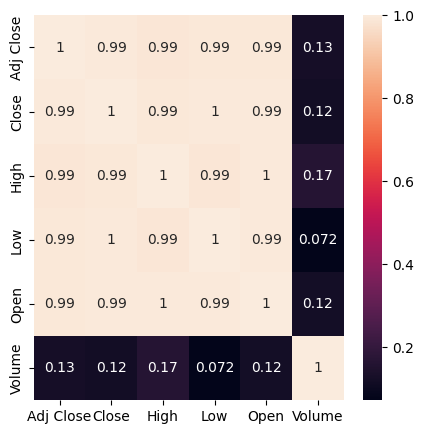

In [10]:
## correlation between the variables
corr_matrix = GME_Daily[['Adj Close', 'Close',	'High',	'Low',	'Open',	'Volume']].corr()

## visualize the correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

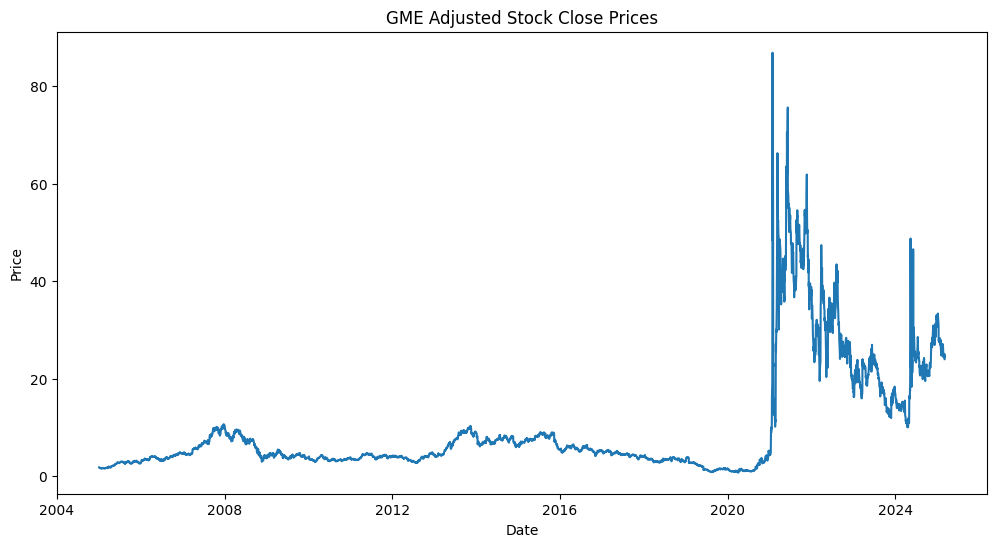

In [11]:
# Visualization of the closing price
plt.figure(figsize=(12,6))
plt.plot(GME_Daily['Adj Close'])
plt.title('GME Adjusted Stock Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

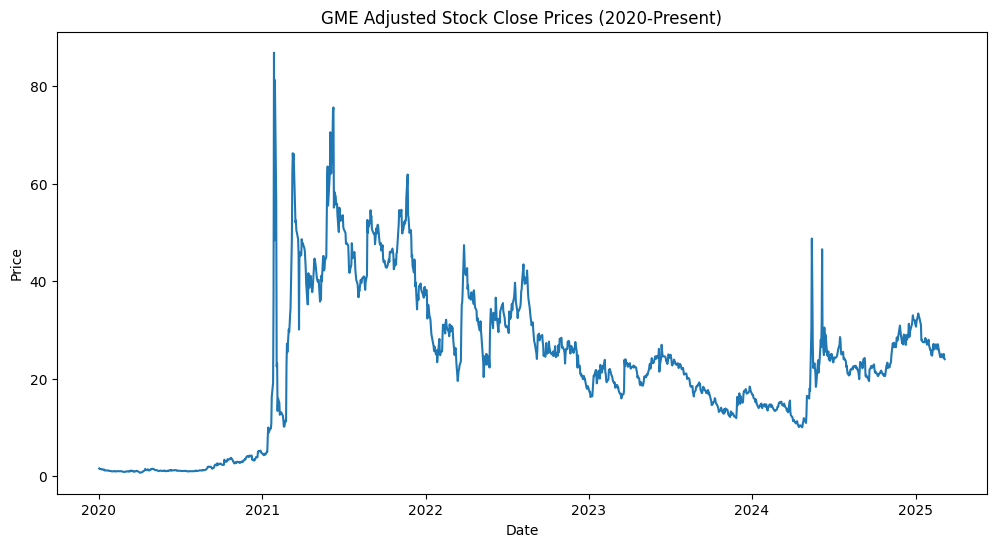

In [12]:
## Consider focussing on data from 2020
GME_recent = GME_Daily.loc['2020-01-01':]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(GME_recent.index, GME_recent['Adj Close'])
plt.title('GME Adjusted Stock Close Prices (2020-Present)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [13]:
## Consider focussing on data from 2020
GME_recent = GME_Daily.loc['2020-01-01':]

## Technical indicators
- Add using the python TA library

In [14]:
## Selected indicators based on price,momentum, volatility and volume


GME_TA = GME_Daily.copy()

# VWAP
vwap = VolumeWeightedAveragePrice(high=GME_TA['High'], low=GME_TA['Low'], close=GME_TA['Close'], volume=GME_TA['Volume'])
GME_TA['vwap'] = vwap.volume_weighted_average_price()

# Moving Averages
GME_TA['sma'] = SMAIndicator(close=GME_TA['Close'], window=20).sma_indicator()
GME_TA['ema'] = EMAIndicator(close=GME_TA['Close'], window=20).ema_indicator()

# Bollinger Bands
bb = BollingerBands(close=GME_TA['Close'], window=20, window_dev=2)
GME_TA['bb_middle'] = bb.bollinger_mavg()
GME_TA['bb_upper'] = bb.bollinger_hband()
GME_TA['bb_lower'] = bb.bollinger_lband()

# MACD
macd = MACD(close=GME_TA['Close'])
GME_TA['macd'] = macd.macd()
GME_TA['macd_signal'] = macd.macd_signal()
GME_TA['macd_diff'] = macd.macd_diff()

# RSI
GME_TA['rsi'] = RSIIndicator(close=GME_TA['Close'], window=14).rsi()

# ATR
GME_TA['atr'] = AverageTrueRange(high=GME_TA['High'], low=GME_TA['Low'], close=GME_TA['Close'], window=14).average_true_range()


#OBV
obv_indicator = OnBalanceVolumeIndicator(close=GME_TA['Close'], volume=GME_TA['Volume'])
GME_TA['obv'] = obv_indicator.on_balance_volume()
# VPT 
GME_TA['vpt'] = (GME_TA['Volume'] * ((GME_TA['Close'] - GME_TA['Close'].shift(1)) / GME_TA['Close'].shift(1))).cumsum()

# Display the first few rows of the new DataFrame
print(GME_TA.head())

            Adj Close    Close     High      Low     Open    Volume  vwap  \
Date                                                                        
2005-01-03   1.812019  2.69125  2.86875  2.65750  2.86875   4844800   NaN   
2005-01-04   1.792662  2.66250  2.70125  2.56625  2.69125   4378400   NaN   
2005-01-05   1.790978  2.66000  2.68125  2.62875  2.63750   3254400   NaN   
2005-01-06   1.780038  2.64375  2.66875  2.64375  2.66000   4820800   NaN   
2005-01-07   1.645377  2.44375  2.48750  2.34375  2.48750  29349600   NaN   

            sma  ema  bb_middle  bb_upper  bb_lower  macd  macd_signal  \
Date                                                                     
2005-01-03  NaN  NaN        NaN       NaN       NaN   NaN          NaN   
2005-01-04  NaN  NaN        NaN       NaN       NaN   NaN          NaN   
2005-01-05  NaN  NaN        NaN       NaN       NaN   NaN          NaN   
2005-01-06  NaN  NaN        NaN       NaN       NaN   NaN          NaN   
2005-01-07  NaN 

In [15]:
GME_TA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5077 entries, 2005-01-03 to 2025-03-07
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Adj Close    5077 non-null   float64
 1   Close        5077 non-null   float64
 2   High         5077 non-null   float64
 3   Low          5077 non-null   float64
 4   Open         5077 non-null   float64
 5   Volume       5077 non-null   int32  
 6   vwap         5064 non-null   float64
 7   sma          5058 non-null   float64
 8   ema          5058 non-null   float64
 9   bb_middle    5058 non-null   float64
 10  bb_upper     5058 non-null   float64
 11  bb_lower     5058 non-null   float64
 12  macd         5052 non-null   float64
 13  macd_signal  5044 non-null   float64
 14  macd_diff    5044 non-null   float64
 15  rsi          5064 non-null   float64
 16  atr          5077 non-null   float64
 17  obv          5077 non-null   int32  
 18  vpt          5076 non-null   f

In [16]:
# Check for missing values in each column
missing_values = GME_TA.isna().sum()
print(missing_values[missing_values > 0])

vwap           13
sma            19
ema            19
bb_middle      19
bb_upper       19
bb_lower       19
macd           25
macd_signal    33
macd_diff      33
rsi            13
vpt             1
dtype: int64


In [17]:
## make a 5 year dataset with the TA features
GME_recent_TA = GME_TA.loc['2020-01-01':]

In [18]:
GME_recent_TA.head()


,Adj Close,Close,High,Low,Open,Volume,vwap,sma,ema,bb_middle,bb_upper,bb_lower,macd,macd_signal,macd_diff,rsi,atr,obv,vpt
Date,,,,,,,,,,,,,,,,,,,
2020-01-02,1.5775,1.5775,1.6175,1.5175,1.5350,17814400,1.453987,1.494375,1.485178,1.494375,1.691351,1.297399,0.004115,-0.004334,0.008449,57.080014,0.097261,306228800,-1.619813e+08
2020-01-03,1.4700,1.4700,1.5625,1.4600,1.5525,14175600,1.461768,1.487500,1.483732,1.487500,1.677684,1.297316,0.002411,-0.002985,0.005396,49.167188,0.098707,292053200,-1.629473e+08
2020-01-06,1.4625,1.4625,1.4775,1.4000,1.4500,13579200,1.469120,1.480625,1.481710,1.480625,1.663859,1.297391,0.000451,-0.002298,0.002749,48.660357,0.097192,278474000,-1.630166e+08
2020-01-07,1.3800,1.3800,1.4575,1.3600,1.4425,20912000,1.469929,1.466125,1.472023,1.466125,1.632216,1.300034,-0.007671,-0.003372,-0.004299,43.364930,0.097571,257562000,-1.641962e+08
2020-01-08,1.4300,1.4300,1.4625,1.3525,1.3725,22517600,1.465633,1.458500,1.468021,1.458500,1.616316,1.300684,-0.009959,-0.004690,-0.005269,47.120804,0.098459,280079600,-1.633804e+08


In [19]:
# Check for missing values in each column
missing_values = GME_recent_TA.isna().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [20]:
GME_recent_TA.describe()

,Adj Close,Close,High,Low,Open,Volume,vwap,sma,ema,bb_middle,bb_upper,bb_lower,macd,macd_signal,macd_diff,rsi,atr,obv,vpt
count,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1.302000e+03,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1.302000e+03,1.302000e+03
mean,22.904359,22.904359,24.094747,21.920488,22.977381,2.318707e+07,23.295404,22.732573,22.730062,22.732573,28.014503,17.450643,0.133791,0.136244,-0.002453,49.257763,2.316022,1.956467e+08,2.255497e+09
std,15.185988,15.185988,16.438206,14.338462,15.393150,5.791892e+07,14.970008,14.587342,14.469769,14.587342,19.053523,13.251179,1.913469,1.678209,0.820885,11.631094,2.602187,1.748366e+09,1.194259e+09
min,0.700000,0.700000,0.735000,0.642500,0.712500,1.122700e+06,0.926985,0.942375,0.900476,0.942375,1.082925,-29.598549,-4.041312,-3.786136,-4.051772,17.687500,0.061928,-2.146864e+09,-1.747166e+08
25%,13.445000,13.445000,13.815000,13.060000,13.462500,4.264750e+06,14.191553,14.065625,14.127016,14.065625,15.560834,7.999824,-0.653760,-0.618759,-0.213028,41.151217,0.722046,-1.956959e+09,2.719039e+09
50%,22.565000,22.565000,23.290000,21.969999,22.517500,8.703400e+06,23.013187,22.441000,22.410165,22.441000,26.279563,18.705233,-0.025934,-0.022548,-0.001887,48.231795,1.535199,5.803109e+08,2.827142e+09
75%,31.089375,31.089375,32.868126,29.728126,31.118750,1.813980e+07,31.594343,30.374000,30.468266,30.374000,39.585583,24.654301,0.489188,0.512838,0.168681,56.120207,3.180261,1.814096e+09,2.854170e+09
max,86.877502,86.877502,120.750000,72.877502,94.927498,7.886316e+08,64.151491,60.565250,58.391764,60.565250,79.572195,47.445571,14.881841,9.556241,7.384551,98.452877,19.352316,2.146341e+09,3.241499e+09


In [21]:
GME_recent_TA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 2020-01-02 to 2025-03-07
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Adj Close    1302 non-null   float64
 1   Close        1302 non-null   float64
 2   High         1302 non-null   float64
 3   Low          1302 non-null   float64
 4   Open         1302 non-null   float64
 5   Volume       1302 non-null   int32  
 6   vwap         1302 non-null   float64
 7   sma          1302 non-null   float64
 8   ema          1302 non-null   float64
 9   bb_middle    1302 non-null   float64
 10  bb_upper     1302 non-null   float64
 11  bb_lower     1302 non-null   float64
 12  macd         1302 non-null   float64
 13  macd_signal  1302 non-null   float64
 14  macd_diff    1302 non-null   float64
 15  rsi          1302 non-null   float64
 16  atr          1302 non-null   float64
 17  obv          1302 non-null   int32  
 18  vpt          1302 non-null   f

In [22]:
# Create a copy of the original DataFrame
GME_recent_clean = GME_recent.copy()

# Drop rows with missing data in the copy
GME_recent_clean.dropna(inplace=True)


In [23]:
GME_recent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 2020-01-02 to 2025-03-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1302 non-null   float64
 1   Close      1302 non-null   float64
 2   High       1302 non-null   float64
 3   Low        1302 non-null   float64
 4   Open       1302 non-null   float64
 5   Volume     1302 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 66.1 KB


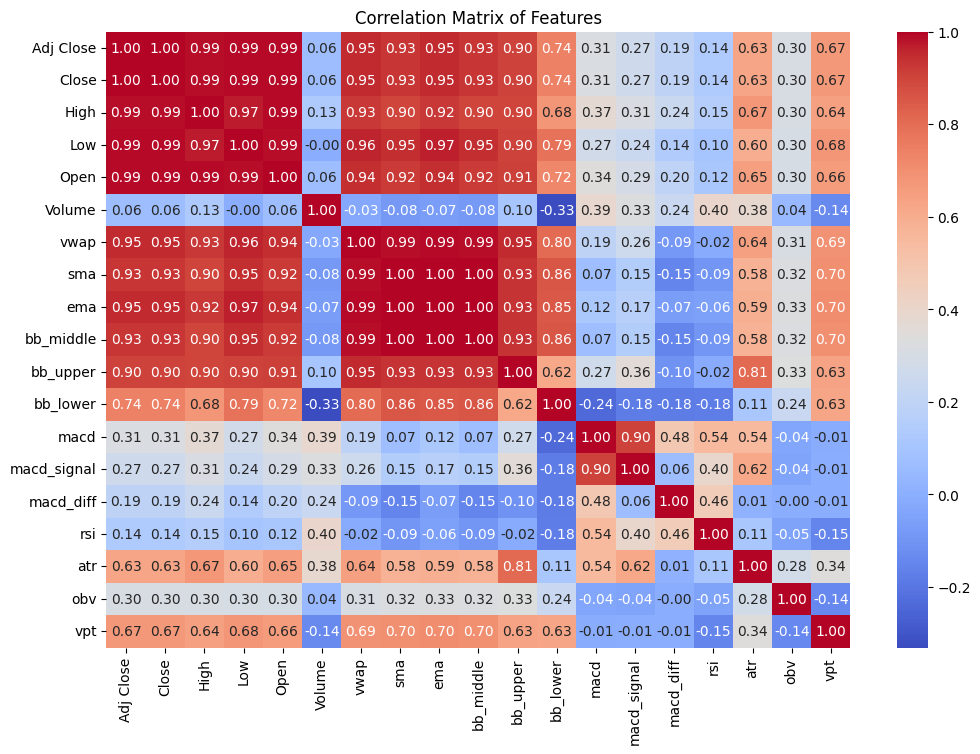

In [24]:
# Compute the correlation matrix
correlation_matrix = GME_recent_TA.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

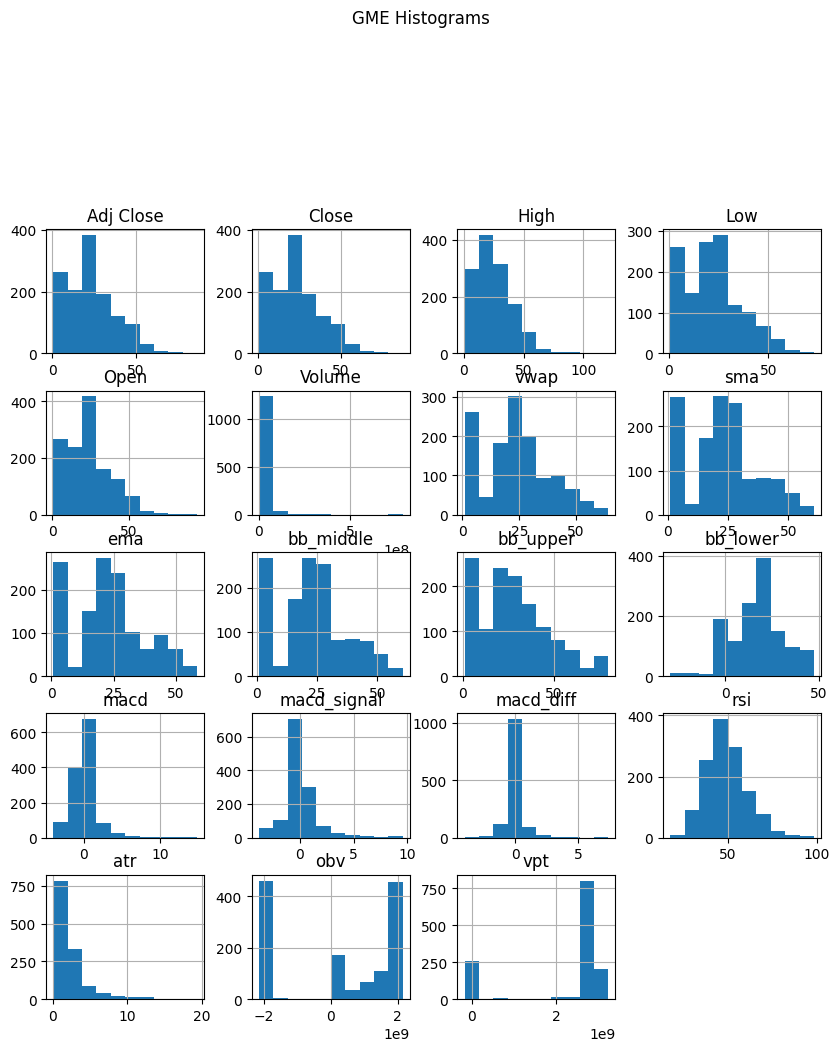

In [25]:
## histogram to look at the distibutions of the GME data
GME_recent_TA.hist(bins=10, figsize=(10,10))
plt.suptitle('GME Histograms', y=1.1)
plt.show()

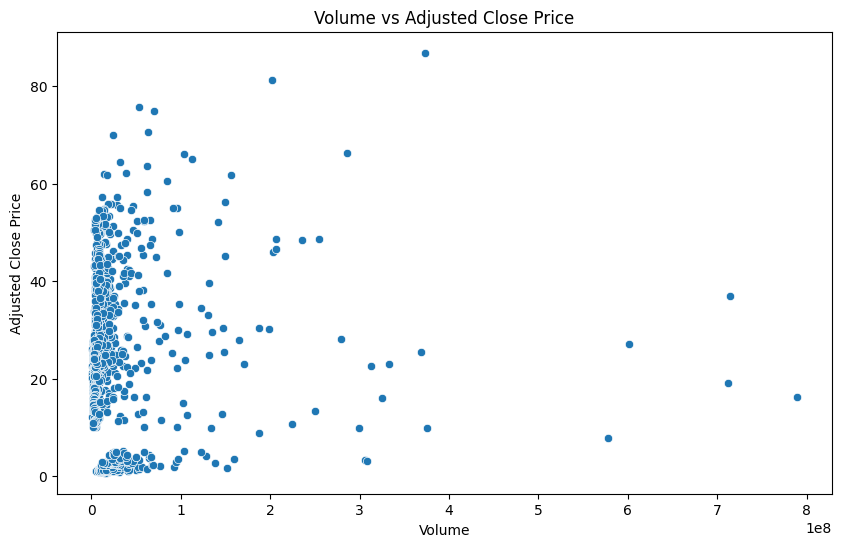

In [26]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=GME_recent_TA, x='Volume', y='Adj Close')

# Add labels and title
plt.xlabel('Volume')
plt.ylabel('Adjusted Close Price')
plt.title('Volume vs Adjusted Close Price')
plt.tight_layout
plt.show()


In [27]:
GME_recent_TA.describe()

,Adj Close,Close,High,Low,Open,Volume,vwap,sma,ema,bb_middle,bb_upper,bb_lower,macd,macd_signal,macd_diff,rsi,atr,obv,vpt
count,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1.302000e+03,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1.302000e+03,1.302000e+03
mean,22.904359,22.904359,24.094747,21.920488,22.977381,2.318707e+07,23.295404,22.732573,22.730062,22.732573,28.014503,17.450643,0.133791,0.136244,-0.002453,49.257763,2.316022,1.956467e+08,2.255497e+09
std,15.185988,15.185988,16.438206,14.338462,15.393150,5.791892e+07,14.970008,14.587342,14.469769,14.587342,19.053523,13.251179,1.913469,1.678209,0.820885,11.631094,2.602187,1.748366e+09,1.194259e+09
min,0.700000,0.700000,0.735000,0.642500,0.712500,1.122700e+06,0.926985,0.942375,0.900476,0.942375,1.082925,-29.598549,-4.041312,-3.786136,-4.051772,17.687500,0.061928,-2.146864e+09,-1.747166e+08
25%,13.445000,13.445000,13.815000,13.060000,13.462500,4.264750e+06,14.191553,14.065625,14.127016,14.065625,15.560834,7.999824,-0.653760,-0.618759,-0.213028,41.151217,0.722046,-1.956959e+09,2.719039e+09
50%,22.565000,22.565000,23.290000,21.969999,22.517500,8.703400e+06,23.013187,22.441000,22.410165,22.441000,26.279563,18.705233,-0.025934,-0.022548,-0.001887,48.231795,1.535199,5.803109e+08,2.827142e+09
75%,31.089375,31.089375,32.868126,29.728126,31.118750,1.813980e+07,31.594343,30.374000,30.468266,30.374000,39.585583,24.654301,0.489188,0.512838,0.168681,56.120207,3.180261,1.814096e+09,2.854170e+09
max,86.877502,86.877502,120.750000,72.877502,94.927498,7.886316e+08,64.151491,60.565250,58.391764,60.565250,79.572195,47.445571,14.881841,9.556241,7.384551,98.452877,19.352316,2.146341e+09,3.241499e+09


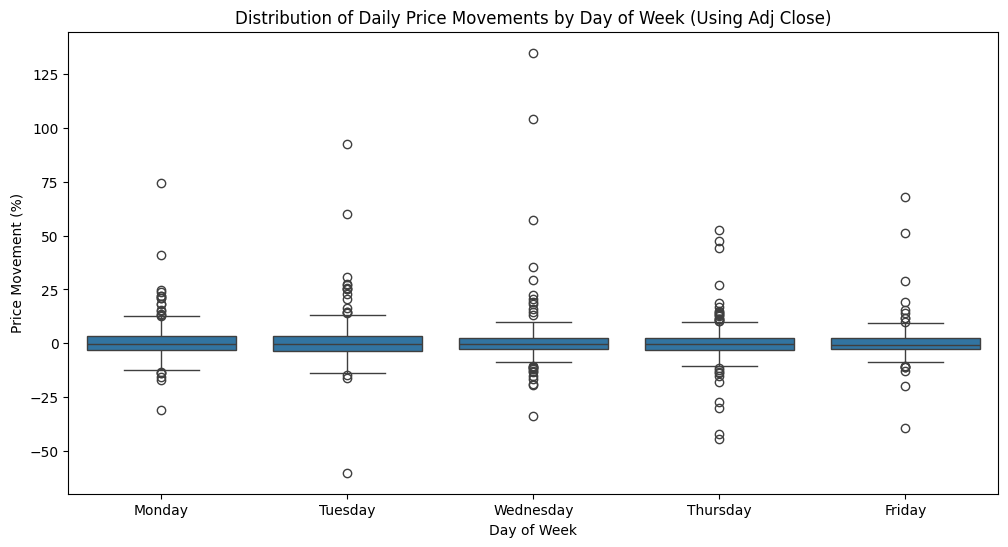

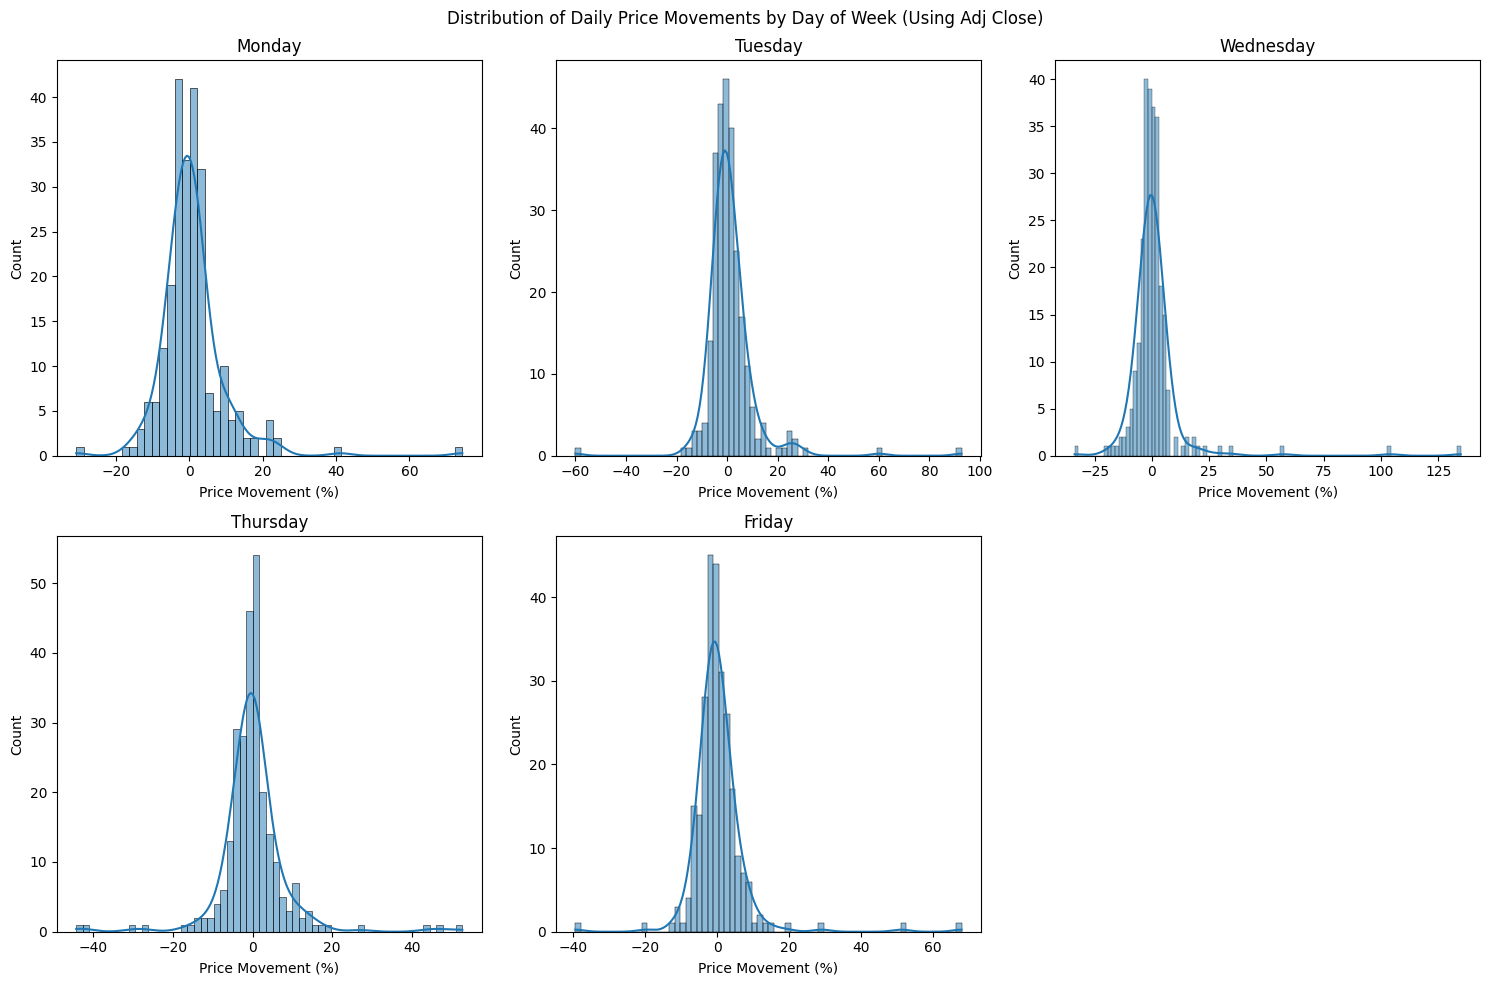

In [31]:
GME_recent_TA = GME_recent_TA.copy()

# Calculate daily price movements using 'Adj Close'
GME_recent_TA['price_movement'] = GME_recent_TA['Adj Close'].pct_change() * 100

# Add a column for the day of the week
GME_recent_TA['Day_of_Week'] = GME_recent_TA.index.day_name()

# Group by day of the week and calculate statistics
day_stats = GME_recent_TA.groupby('Day_of_Week')['price_movement'].describe()


# Visualize the distribution of price movements for each day
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day_of_Week', y='price_movement', data=GME_recent_TA, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Distribution of Daily Price Movements by Day of Week (Using Adj Close)')
plt.xlabel('Day of Week')
plt.ylabel('Price Movement (%)')
plt.show()

# Visualize the distribution using histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Daily Price Movements by Day of Week (Using Adj Close)')

for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']):
    ax = axes[i // 3, i % 3]
    sns.histplot(data=GME_recent_TA[GME_recent_TA['Day_of_Week'] == day], x='price_movement', ax=ax, kde=True)
    ax.set_title(day)
    ax.set_xlabel('Price Movement (%)')

# Remove the last empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

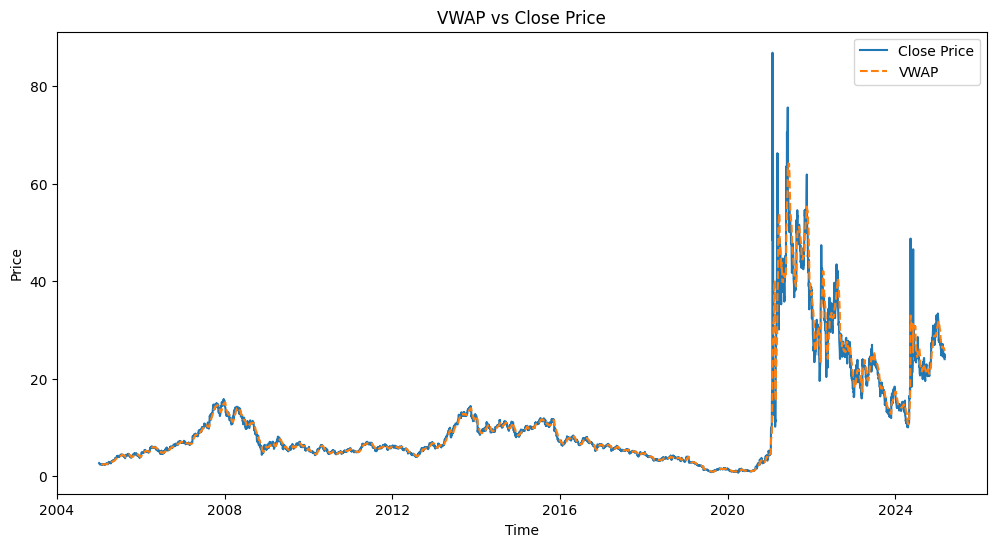

In [32]:
# Plotting the VWAP
plt.figure(figsize=(12, 6))
plt.plot(GME_TA.index, GME_TA['Close'], label='Close Price')
plt.plot(GME_TA.index, GME_TA['vwap'], label='VWAP', linestyle='--')
plt.title('VWAP vs Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 1 Identifying Support and Resistance levels

## Kmeans to identify Clusters to use as support and resistance when modelling 


In [33]:
##Standardised scaler
scaler = StandardScaler()
GME_recent_scale=scaler.fit_transform(GME_recent_clean)
GME_recent_scale = pd.DataFrame(GME_recent_scale, columns = GME_recent_clean.columns)
GME_recent_scale.head()

,Adj Close,Close,High,Low,Open,Volume
0,-1.404917,-1.404917,-1.367904,-1.423502,-1.393517,-0.092797
1,-1.411999,-1.411999,-1.371251,-1.427514,-1.392380,-0.155647
2,-1.412493,-1.412493,-1.376424,-1.431700,-1.399041,-0.165948
3,-1.417927,-1.417927,-1.377641,-1.434491,-1.399529,-0.039295
4,-1.414634,-1.414634,-1.377337,-1.435014,-1.404078,-0.011563


In [34]:
Price_features = GME_recent_clean[['Adj Close', 'Close', 'High', 'Low']]
Price_features

,Adj Close,Close,High,Low
Date,,,,
2020-01-02,1.577500,1.577500,1.617500,1.517500
2020-01-03,1.470000,1.470000,1.562500,1.460000
2020-01-06,1.462500,1.462500,1.477500,1.400000
2020-01-07,1.380000,1.380000,1.457500,1.360000
2020-01-08,1.430000,1.430000,1.462500,1.352500
...,...,...,...,...
2025-03-03,24.400000,24.400000,25.480000,24.180000
2025-03-04,24.299999,24.299999,24.860001,23.440001
2025-03-05,25.070000,25.070000,25.160000,24.110001


In [35]:
Price_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 2020-01-02 to 2025-03-07
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1302 non-null   float64
 1   Close      1302 non-null   float64
 2   High       1302 non-null   float64
 3   Low        1302 non-null   float64
dtypes: float64(4)
memory usage: 50.9 KB


In [36]:
##Standardised scaler
scaler = StandardScaler()
Price_features_scale=scaler.fit_transform(Price_features)
Price_features_scale = pd.DataFrame(Price_features_scale, columns = Price_features.columns)
Price_features_scale.head()

,Adj Close,Close,High,Low
0,-1.404917,-1.404917,-1.367904,-1.423502
1,-1.411999,-1.411999,-1.371251,-1.427514
2,-1.412493,-1.412493,-1.376424,-1.431700
3,-1.417927,-1.417927,-1.377641,-1.434491
4,-1.414634,-1.414634,-1.377337,-1.435014


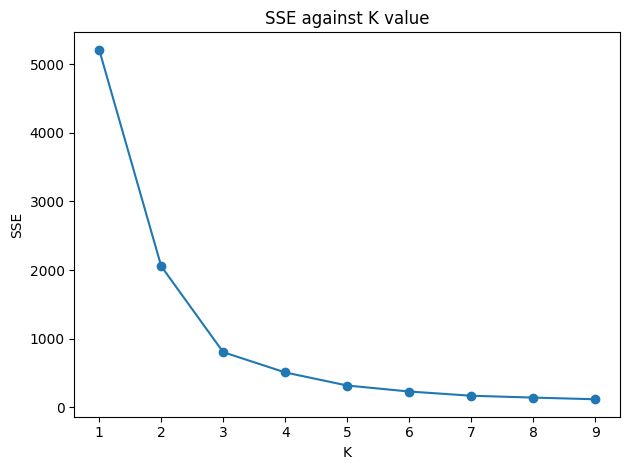

In [37]:
# Determine the optimal K value
sse = []
k_values = range(1,10)
for k in k_values:
    km = KMeans(n_clusters=k)
    km.fit(Price_features_scale)
    sse.append(km.inertia_)

# Visualise the optimal K value to see the elbow
plt.plot(k_values, sse, marker = 'o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE against K value')
plt.tight_layout()
plt.show()

Silhouette score for k = 2: 0.537
Silhouette score for k = 3: 0.621
Silhouette score for k = 4: 0.583
Silhouette score for k = 5: 0.604
Silhouette score for k = 6: 0.608
Silhouette score for k = 7: 0.601
Silhouette score for k = 8: 0.578
Silhouette score for k = 9: 0.579
Silhouette score for k = 10: 0.571


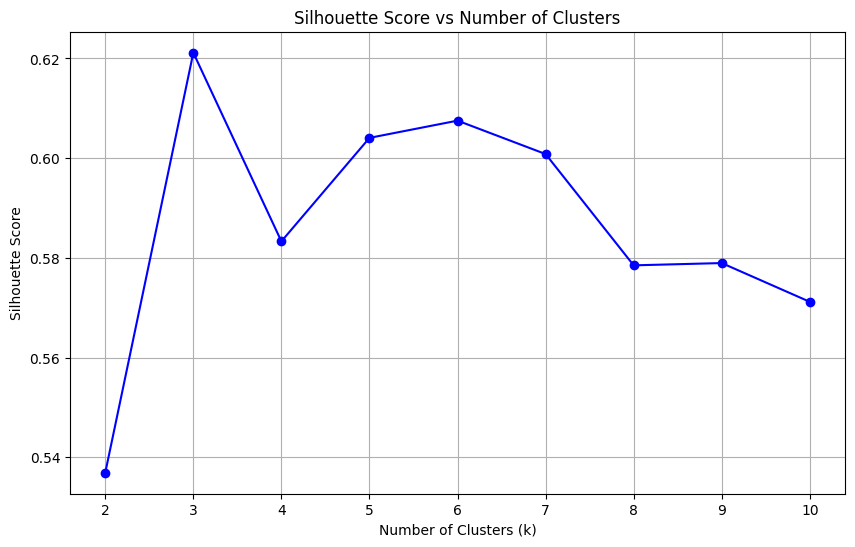


Optimal number of clusters: 3


In [38]:
# Using silhouette score for Kmeans to determine the optimal k value
# Score ranges from -1 to 1
from sklearn.metrics import silhouette_score

sil_scores = []
k_range = range(2, 11)

for k in k_range:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit and predict on scaled data
    cluster_labels = kmeans.fit_predict(Price_features_scale)
    # Calculate silhouette score
    score = silhouette_score(Price_features_scale, cluster_labels)
    sil_scores.append(score)
    print(f'Silhouette score for k = {k}: {score:.3f}')

# Visualize the results
plt.figure(figsize=(10,6))
plt.plot(k_range, sil_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Find the optimal k
optimal_k = k_range[np.argmax(sil_scores)]
print(f'\nOptimal number of clusters: {optimal_k}')

In [39]:
## use the cluster to be 3
km = KMeans(n_clusters=3, random_state=42)
y_pred = km.fit_predict(Price_features_scale)
y_pred

array([2, 2, 2, ..., 1, 1, 1])

In [40]:
Price_features_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1302 non-null   float64
 1   Close      1302 non-null   float64
 2   High       1302 non-null   float64
 3   Low        1302 non-null   float64
dtypes: float64(4)
memory usage: 40.8 KB


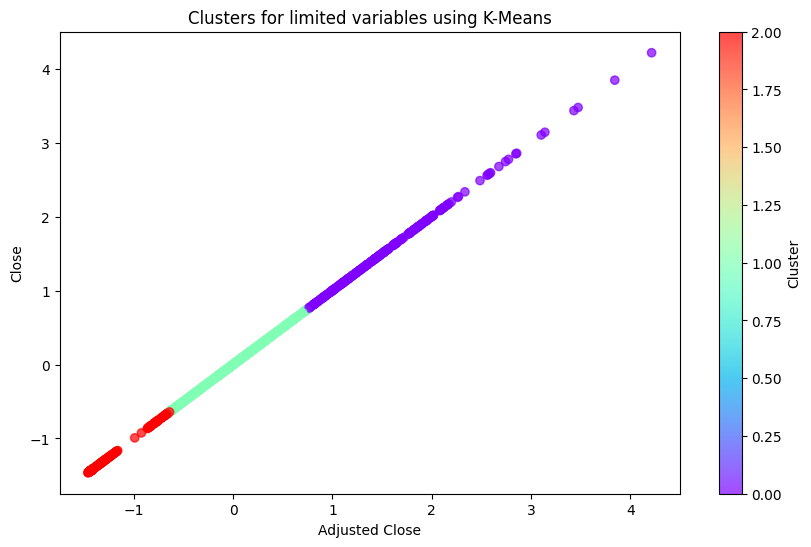

In [41]:
## visualise the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(Price_features_scale.iloc[:, 0], Price_features_scale.iloc[:, 1], c=y_pred, cmap='rainbow', alpha=0.7)
plt.xlabel('Adjusted Close')
plt.ylabel('Close')
plt.title('Clusters for limited variables using K-Means')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [42]:
# Assuming you scaled multiple columns
features = ['Adj Close', 'High', 'Low', 'Open']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(GME_recent_clean[features])

# After clustering, you have cluster centers
cluster_centers = kmeans.cluster_centers_

# Inverse transform the cluster centers
original_cluster_centers = scaler.inverse_transform(cluster_centers)

# Create a DataFrame for easy interpretation
cluster_means = pd.DataFrame(original_cluster_centers, columns=features)

print(cluster_means)

   Adj Close       High         Low       Open
0  44.751333  47.743197   41.686608  45.259120
1  19.597366  20.515063   18.576900  19.859994
2   1.883937   1.341006    2.633230   1.370997
3  29.984000  31.758167   28.556854  30.113411
4  68.955536  73.943249   68.637165  64.468285
5  37.648278  40.054432   35.120826  38.240047
6  52.804432  56.460344   49.764148  53.503479
7  13.667424  14.096146   13.320592  13.612191
8  48.400002  51.692730  106.229424  29.571178
9  24.282190  25.586192   23.052337  24.655226


In [43]:
GME_recent_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 2020-01-02 to 2025-03-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1302 non-null   float64
 1   Close      1302 non-null   float64
 2   High       1302 non-null   float64
 3   Low        1302 non-null   float64
 4   Open       1302 non-null   float64
 5   Volume     1302 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 66.1 KB


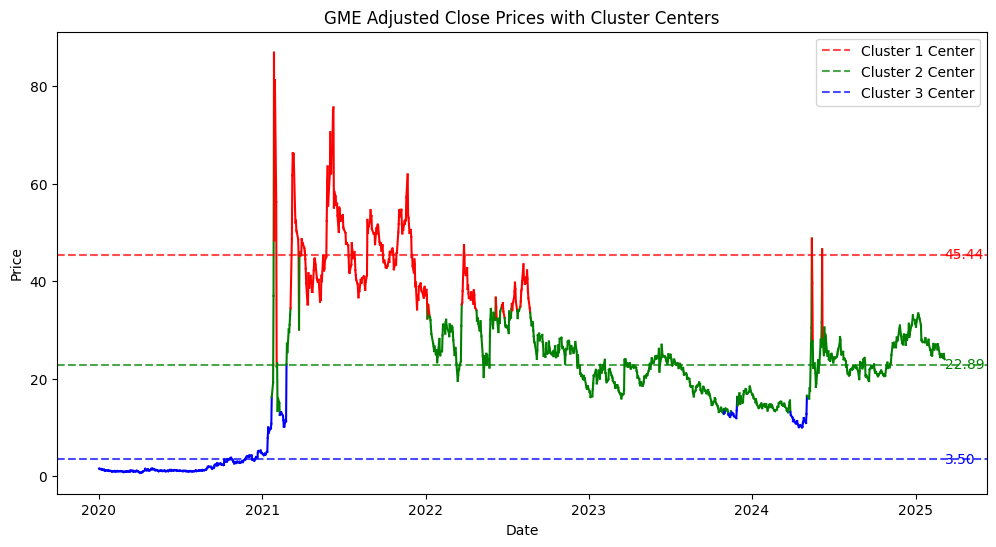

In [44]:

GME_recent=GME_recent.copy()

# Assuming Price_features_scale is your scaled data
km = KMeans(n_clusters=3, random_state=42)
y_pred = km.fit_predict(Price_features_scale)

# Add cluster labels to the DataFrame
GME_recent['Cluster'] = y_pred

# Inverse transform the cluster centers
scaler = StandardScaler()
scaled_features = scaler.fit_transform(GME_recent[['Adj Close', 'High', 'Low', 'Open']])
cluster_centers = scaler.inverse_transform(km.cluster_centers_)

# Plot the adjusted close prices with color coding based on clusters
plt.figure(figsize=(12, 6))

# Plot the entire line, changing colors at cluster boundaries
colors = ['red', 'green', 'blue']
for i in range(len(GME_recent) - 1):
    plt.plot(GME_recent.index[i:i+2], GME_recent['Adj Close'].iloc[i:i+2], color=colors[GME_recent['Cluster'].iloc[i]])

# Plot the cluster centers and annotate them
for i, center in enumerate(cluster_centers[:, 0]): 
    plt.axhline(y=center, linestyle='--', color=colors[i], label=f'Cluster {i+1} Center', alpha=0.7)
    plt.text(GME_recent.index[-1], center, f'{center:.2f}', va='center', ha='left', color=colors[i])


plt.title('GME Adjusted Close Prices with Cluster Centers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Look at a subset of recent data for 1 year

In [45]:
# Subset the data for the last year
GME_recent_small = GME_recent.loc['2024-01-01':]

# Select and standardize features
features_small = GME_recent_small[['Adj Close', 'High', 'Low', 'Open']]
scaler_small = StandardScaler()
scaled_features_small = scaler_small.fit_transform(features_small)




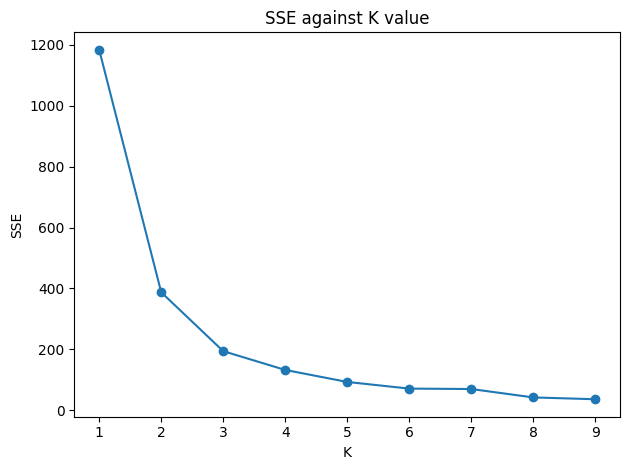

In [46]:
# Determine the optimal K value

sse = []
k_values = range(1,10)
for k in k_values:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features_small)
    sse.append(km.inertia_)

# Visualise the optimal K value to see the elbow
plt.plot(k_values, sse, marker = 'o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE against K value')
plt.tight_layout()
plt.show()

Silhouette score for k = 2: 0.655
Silhouette score for k = 3: 0.660
Silhouette score for k = 4: 0.621
Silhouette score for k = 5: 0.591
Silhouette score for k = 6: 0.576
Silhouette score for k = 7: 0.554
Silhouette score for k = 8: 0.509
Silhouette score for k = 9: 0.527
Silhouette score for k = 10: 0.530


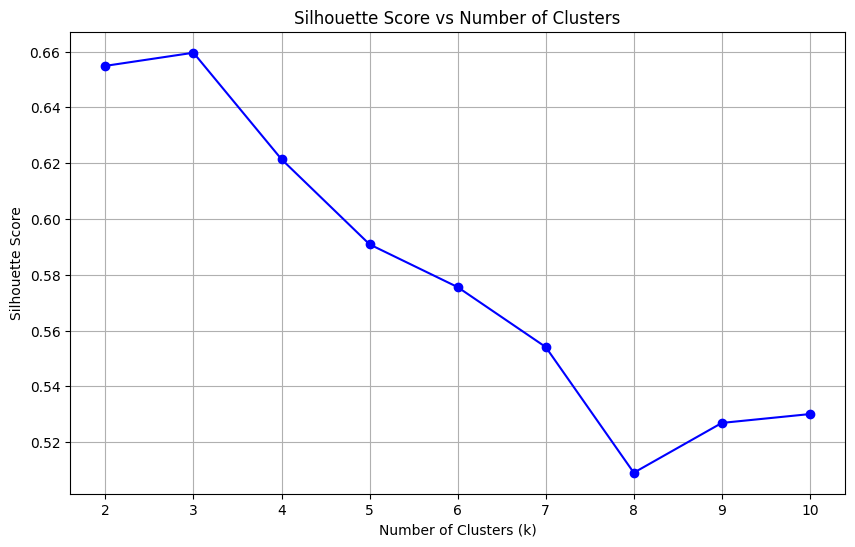


Optimal number of clusters: 3


In [47]:
# Using silhouette score for Kmeans to determine the optimal k value
# Score ranges from -1 to 1


sil_scores = []
k_range = range(2, 11)

for k in k_range:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit and predict on scaled data
    cluster_labels = kmeans.fit_predict(scaled_features_small)
    # Calculate silhouette score
    score = silhouette_score(scaled_features_small, cluster_labels)
    sil_scores.append(score)
    print(f'Silhouette score for k = {k}: {score:.3f}')

# Visualize the results
plt.figure(figsize=(10,6))
plt.plot(k_range, sil_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Find the optimal k
optimal_k = k_range[np.argmax(sil_scores)]
print(f'\nOptimal number of clusters: {optimal_k}')

In [48]:
## use the cluster to be 3
km = KMeans(n_clusters=3, random_state=42)
y_pred_small = km.fit_predict(scaled_features_small)
y_pred_small

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

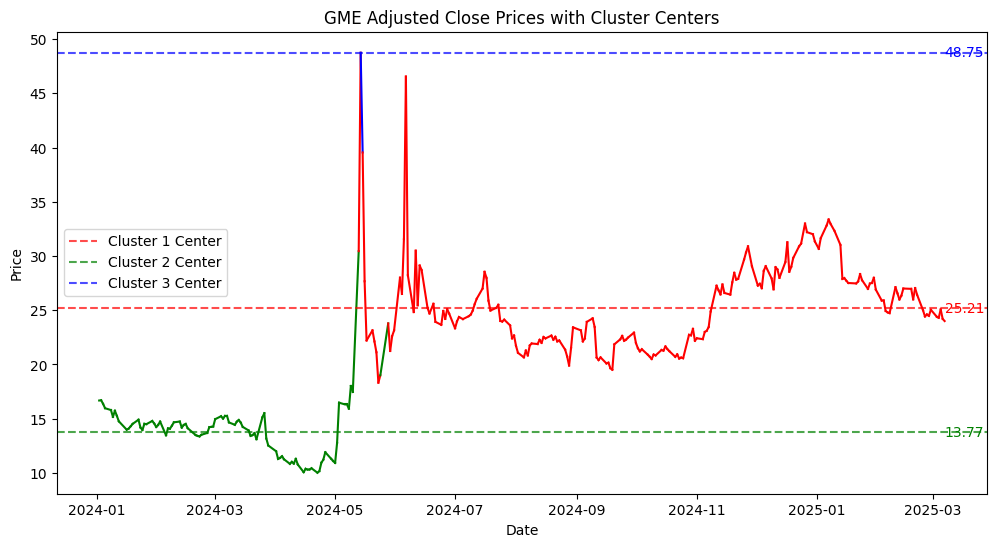

In [49]:
# Add cluster labels to the DataFrame *** Changed 
GME_recent_small.loc[:, 'Cluster'] = y_pred_small


# Inverse transform the cluster centers
scaler = StandardScaler()
scaled_features_small = scaler.fit_transform(GME_recent_small[['Adj Close', 'High', 'Low', 'Open']]) ## this was GME_recent ?
cluster_centers_small = scaler.inverse_transform(km.cluster_centers_)

# Plot the adjusted close prices with color coding based on clusters
plt.figure(figsize=(12, 6))

# Plot the entire line, changing colors at cluster boundaries
colors = ['red', 'green', 'blue']
for i in range(len(GME_recent_small) - 1):
    plt.plot(GME_recent_small.index[i:i+2], GME_recent_small['Adj Close'].iloc[i:i+2], color=colors[GME_recent_small['Cluster'].iloc[i]])

# Plot the cluster centers and annotate them
for i, center in enumerate(cluster_centers_small[:, 0]): 
    plt.axhline(y=center, linestyle='--', color=colors[i], label=f'Cluster {i+1} Center', alpha=0.7)
    plt.text(GME_recent_small.index[-1], center, f'{center:.2f}', va='center', ha='left', color=colors[i])


plt.title('GME Adjusted Close Prices with Cluster Centers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Consider Volume Profile 
Volume profile is another way to identify possible areas of support and resistance.

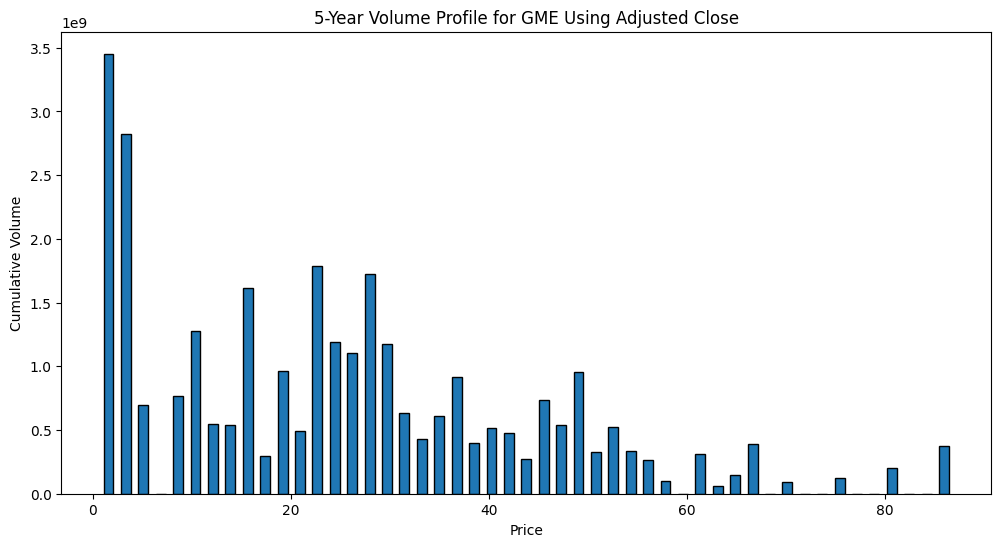

In [50]:
# Create a copy of the DataFrame 
GME_recent_copy = GME_recent.copy()

# Adjusting price bins
price_bins = np.linspace(GME_recent_copy['Adj Close'].min(), GME_recent_copy['Adj Close'].max(), num=50)
GME_recent_copy.loc[:, 'price_bin'] = pd.cut(GME_recent_copy['Adj Close'], bins=price_bins)

# Aggregate volume per price bin, explicitly setting observed=False
volume_profile = GME_recent_copy.groupby('price_bin', observed=False)['Volume'].sum()

# Use bin midpoints for x-axis labels
bin_midpoints = [interval.mid for interval in volume_profile.index]

# Visualizing the volume profile
plt.figure(figsize=(12, 6))
plt.bar(x=bin_midpoints, height=volume_profile.values, width=1, edgecolor='black')
plt.title('5-Year Volume Profile for GME Using Adjusted Close')
plt.xlabel('Price')
plt.ylabel('Cumulative Volume')
plt.show()

Top Volume Levels:
price_bin
(0.7, 2.459]        3452578000
(2.459, 4.217]      2820749600
(21.805, 23.563]    1790090300
(27.081, 28.84]     1720452300
(14.77, 16.529]     1612647900
Name: Volume, dtype: int64


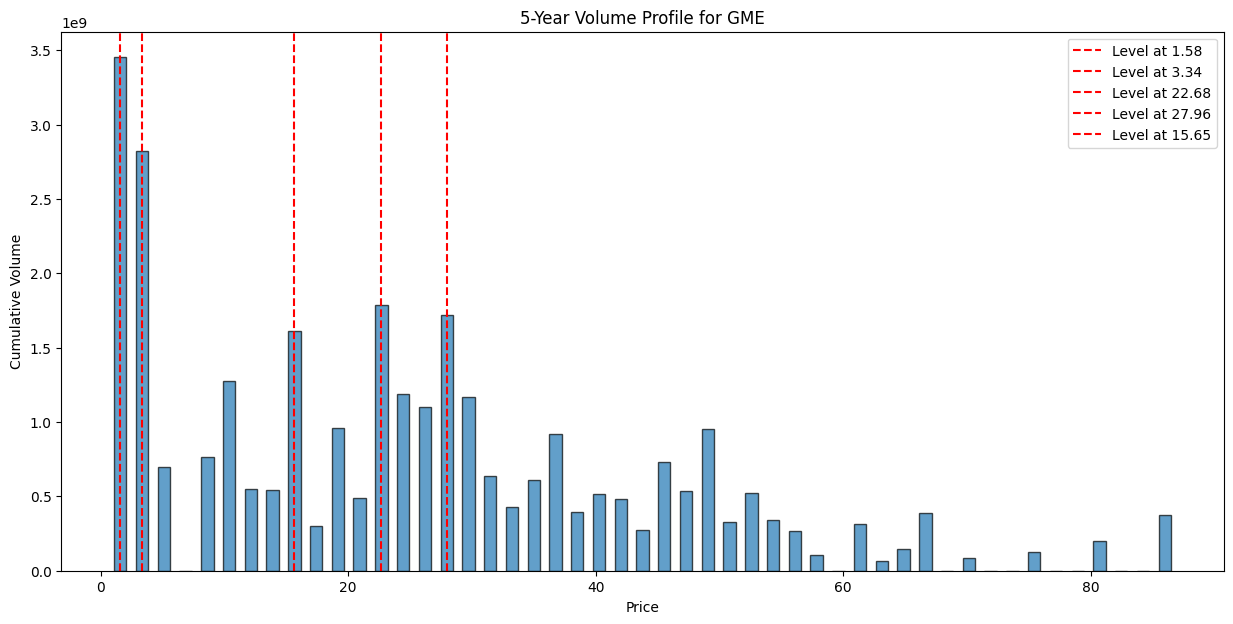

In [51]:
# Find top volume areas
top_volume_levels = volume_profile.nlargest(5)
print("Top Volume Levels:")
print(top_volume_levels)

# Visualize with top levels highlighted
plt.figure(figsize=(15, 7))
plt.bar(x=bin_midpoints, height=volume_profile.values, width=1, edgecolor='black', alpha=0.7)
plt.title('5-Year Volume Profile for GME')
plt.xlabel('Price')
plt.ylabel('Cumulative Volume')

# Highlight top volume levels
for price, volume in top_volume_levels.items():
    plt.axvline(x=price.mid, color='r', linestyle='--', 
                label=f'Level at {price.mid:.2f}')

plt.legend()
plt.show()

In [52]:
GME_recent_TA = GME_recent_TA.copy()
GME_recent_TA.loc[:, 'Cluster'] = y_pred

In [53]:
volume_profile_levels = [1.58, 3.34, 15.65, 22.68, 27.96]


In [54]:
# Add distance to each volume profile level as a new column - possible support and resistance lines
for level in volume_profile_levels:
    col_name = f'distance_to_level_{level}'
    GME_recent_TA[col_name] = abs(GME_recent_TA['Adj Close'] - level)

# Display the updated DataFrame
print(GME_recent_TA[[f'distance_to_level_{level}' for level in volume_profile_levels]].head())


            distance_to_level_1.58  distance_to_level_3.34  \
Date                                                         
2020-01-02                  0.0025                  1.7625   
2020-01-03                  0.1100                  1.8700   
2020-01-06                  0.1175                  1.8775   
2020-01-07                  0.2000                  1.9600   
2020-01-08                  0.1500                  1.9100   

            distance_to_level_15.65  distance_to_level_22.68  \
Date                                                           
2020-01-02                  14.0725                  21.1025   
2020-01-03                  14.1800                  21.2100   
2020-01-06                  14.1875                  21.2175   
2020-01-07                  14.2700                  21.3000   
2020-01-08                  14.2200                  21.2500   

            distance_to_level_27.96  
Date                                 
2020-01-02                  26.3825  
20

In [55]:
GME_recent_TA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 2020-01-02 to 2025-03-07
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Adj Close                1302 non-null   float64
 1   Close                    1302 non-null   float64
 2   High                     1302 non-null   float64
 3   Low                      1302 non-null   float64
 4   Open                     1302 non-null   float64
 5   Volume                   1302 non-null   int32  
 6   vwap                     1302 non-null   float64
 7   sma                      1302 non-null   float64
 8   ema                      1302 non-null   float64
 9   bb_middle                1302 non-null   float64
 10  bb_upper                 1302 non-null   float64
 11  bb_lower                 1302 non-null   float64
 12  macd                     1302 non-null   float64
 13  macd_signal              1302 non-null   float64
 14  macd_d

## Step 2 - 5% Moves 

In [60]:
## Create a target column for predictions  
def create_three_class_target(df, up_threshold=0.05, down_threshold=-0.05):
    """
    Create a three-class target for price movement
    2: Significant price increase (>5%)
    1: Neutral (-5% to 5%)
    0: Significant price decrease (<-5%)
    """
    # Use Adjusted Close for more accurate price movement
    df['price_movement'] = df['Adj Close'].pct_change()
    
    # Create three-class target
    def classify_movement(change):
        if change > up_threshold:
            return 2  # Significant increase
        elif change < down_threshold:
            return 0  # Significant decrease
        else:
            return 1  # Neutral
    
    df['target'] = df['price_movement'].apply(classify_movement)
    
    # Drop NaN values
    df = df.dropna()
    
    return df

# Apply the function
GME_recent_TA = create_three_class_target(GME_recent_TA)


In [61]:
# Create dataframes to examine the up and downs in more detail
GME_up = GME_recent_TA[GME_recent_TA['target'] == 2].copy()

# Extract rows where the target is 0 (Significant price decrease)
GME_down = GME_recent_TA[GME_recent_TA['target'] == 0].copy()


In [62]:
GME_up.describe()

,Adj Close,Close,High,Low,Open,Volume,vwap,sma,ema,bb_middle,...,obv,vpt,price_movement,Cluster,distance_to_level_1.58,distance_to_level_3.34,distance_to_level_15.65,distance_to_level_22.68,distance_to_level_27.96,target
count,195.000000,195.000000,195.000000,195.000000,195.000000,1.950000e+02,195.000000,195.000000,195.000000,195.000000,...,1.950000e+02,1.950000e+02,195.000000,195.000000,195.000000,195.000000,195.000000,1.950000e+02,195.000000,195.0
mean,24.693321,24.693321,26.194295,21.800346,23.111949,6.792493e+07,22.083474,21.004113,21.235082,21.004113,...,5.023175e+08,2.047953e+09,0.143646,1.066667,23.217244,21.991551,16.135449,1.435683e+01,14.652500,2.0
std,18.368664,18.368664,20.063331,15.950244,17.853325,1.234149e+08,15.543314,14.969921,14.967347,14.969921,...,1.596795e+09,1.274998e+09,0.166616,0.725576,18.236452,17.595487,12.566474,1.158883e+01,11.503546,0.0
min,0.772500,0.772500,0.800000,0.707500,0.715000,3.172200e+06,0.930175,0.942375,0.905526,0.942375,...,-2.137270e+09,-1.730842e+08,0.050398,0.000000,0.067500,0.032500,0.292500,3.051758e-07,0.040000,2.0
25%,8.845000,8.845000,10.213750,6.635000,7.313750,1.201700e+07,6.843274,4.817625,5.031219,4.817625,...,-1.698267e+09,5.016761e+08,0.063911,1.000000,7.265000,5.505000,8.784999,5.120000e+00,4.094999,2.0
50%,24.570000,24.570000,25.100000,22.535000,22.850000,2.434000e+07,23.625635,22.014500,22.180329,22.014500,...,1.080860e+09,2.758823e+09,0.088902,1.000000,22.990000,21.230000,13.350000,1.192250e+01,12.017500,2.0
75%,33.782499,33.782499,37.486250,30.133750,31.642500,6.154600e+07,30.448439,28.234000,29.089527,28.234000,...,1.867842e+09,2.852065e+09,0.143440,2.000000,32.202499,30.442499,18.132499,2.125125e+01,24.728749,2.0
max,86.877502,86.877502,103.495003,70.250000,94.927498,7.886316e+08,62.895650,60.441375,58.102498,60.441375,...,2.140029e+09,3.241499e+09,1.348358,2.000000,85.297502,83.537502,71.227502,6.419750e+01,58.917502,2.0


In [63]:
GME_down.describe()

,Adj Close,Close,High,Low,Open,Volume,vwap,sma,ema,bb_middle,...,obv,vpt,price_movement,Cluster,distance_to_level_1.58,distance_to_level_3.34,distance_to_level_15.65,distance_to_level_22.68,distance_to_level_27.96,target
count,173.000000,173.000000,173.000000,173.000000,173.000000,1.730000e+02,173.000000,173.000000,173.000000,173.000000,...,1.730000e+02,1.730000e+02,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.0
mean,22.445072,22.445072,25.482630,21.654090,24.507717,3.546934e+07,24.637231,23.294634,23.376681,23.294634,...,6.441970e+08,2.132750e+09,-0.097209,1.063584,21.018049,19.844870,13.694089,12.281575,13.391546,0.0
std,15.473246,15.473246,19.045250,14.780823,17.353849,5.925185e+07,15.938767,15.160829,15.138309,15.160829,...,1.552223e+09,1.230990e+09,0.074443,0.716502,15.263582,14.506507,9.861259,9.368181,9.467653,0.0
min,0.712500,0.712500,0.837500,0.712500,0.815000,2.726800e+06,0.926985,0.965000,0.953956,0.965000,...,-2.146026e+09,-1.741993e+08,-0.600000,0.000000,0.022500,0.012500,0.260000,0.050001,0.044999,0.0
25%,11.290000,11.290000,12.217500,11.180000,12.122500,7.381200e+06,13.679697,13.243500,13.419142,13.243500,...,1.634572e+08,2.021579e+09,-0.108747,1.000000,9.710000,7.950000,6.775000,3.152500,4.827498,0.0
50%,22.870001,22.870001,24.670000,22.000000,24.549999,1.464440e+07,26.513497,25.489375,25.279900,25.489375,...,1.460732e+09,2.759913e+09,-0.072107,1.000000,21.290001,19.530001,12.477500,10.150000,11.630000,0.0
75%,31.900000,31.900000,35.724998,30.000000,34.697498,3.056110e+07,33.249761,32.606125,32.050673,32.606125,...,1.924983e+09,2.829456e+09,-0.058559,2.000000,30.320000,28.560000,16.250000,21.122500,24.082500,0.0
max,64.544998,64.544998,120.750000,60.529999,79.139999,3.687768e+08,63.898924,59.936500,58.078025,59.936500,...,2.135772e+09,3.143464e+09,-0.050307,2.000000,62.964998,61.204998,48.894998,41.864998,36.584998,0.0


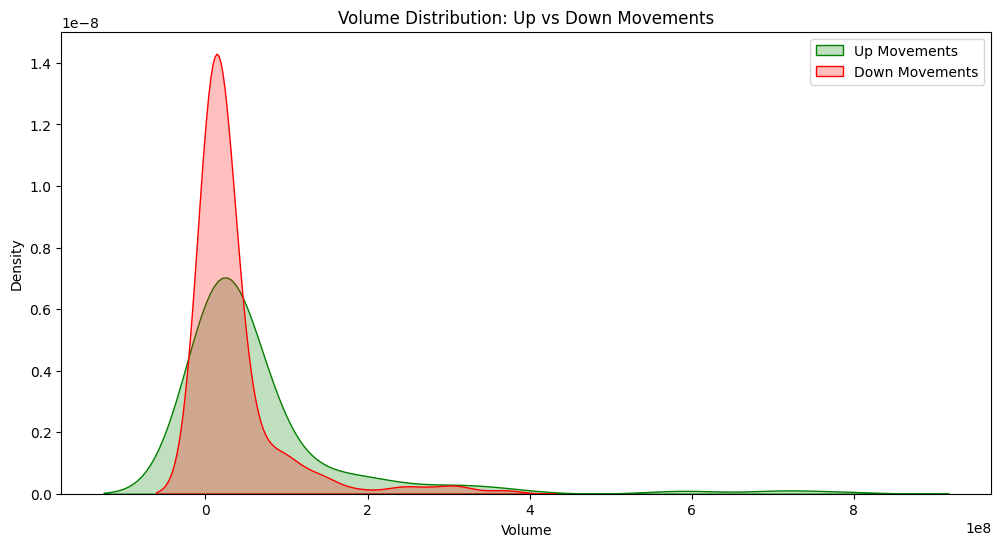

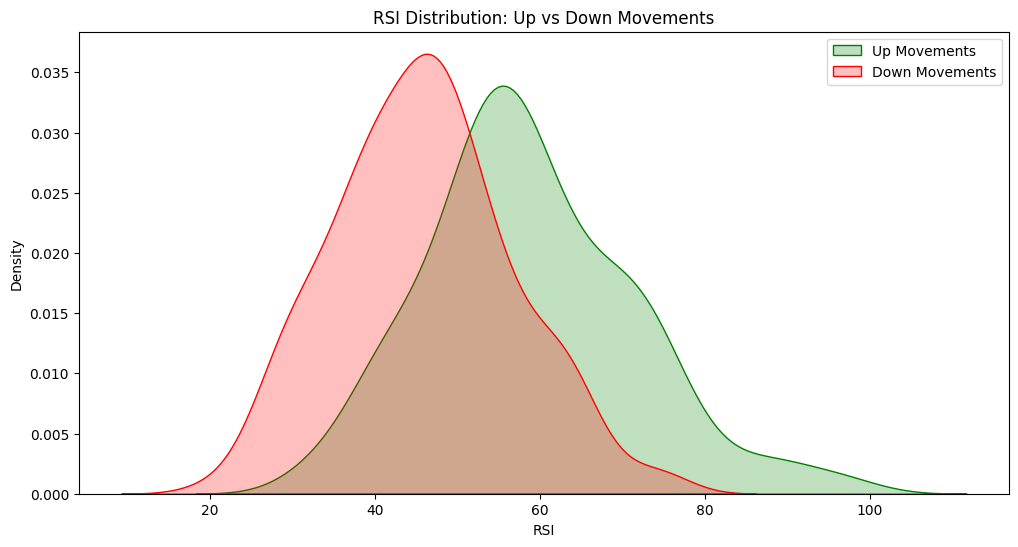

In [64]:
# Visualize Volume Difference
plt.figure(figsize=(12, 6))
sns.kdeplot(GME_up['Volume'], label='Up Movements', color='green', fill=True)
sns.kdeplot(GME_down['Volume'], label='Down Movements', color='red', fill=True)
plt.title('Volume Distribution: Up vs Down Movements')
plt.xlabel('Volume')
plt.legend()
plt.show()

# Visualize RSI Differences
plt.figure(figsize=(12, 6))
sns.kdeplot(GME_up['rsi'], label='Up Movements', color='green', fill=True)
sns.kdeplot(GME_down['rsi'], label='Down Movements', color='red', fill=True)
plt.title('RSI Distribution: Up vs Down Movements')
plt.xlabel('RSI')
plt.legend()
plt.show()


In [65]:


# Up and down volume samples
up_volume = GME_up['Volume']
down_volume = GME_down['Volume']

# Perform a t-test
t_stat, p_value = ttest_ind(up_volume, down_volume)
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.5f}")

if p_value < 0.05:
    print("The difference in volume between up and down movements is statistically significant.")
else:
    print("The difference in volume between up and down movements is not statistically significant.")


T-Statistic: 3.15, P-Value: 0.00176
The difference in volume between up and down movements is statistically significant.


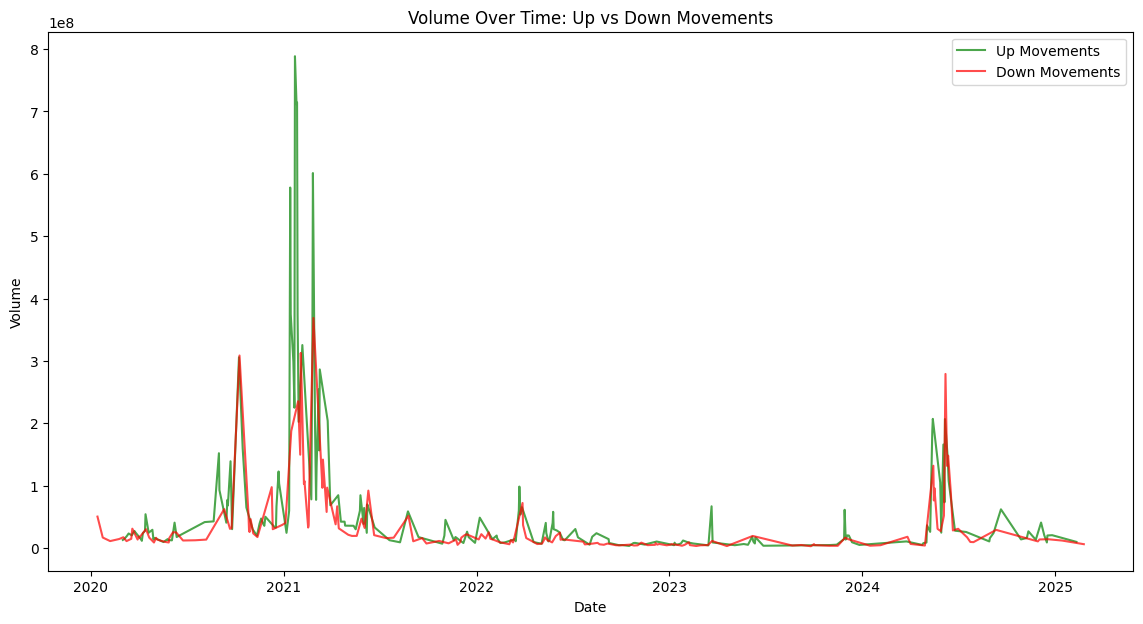

In [66]:


# Plot volume trends over time for up and down movements
plt.figure(figsize=(14, 7))

# Up movements
plt.plot(GME_up.index, GME_up['Volume'], label='Up Movements', color='green', alpha=0.7)

# Down movements
plt.plot(GME_down.index, GME_down['Volume'], label='Down Movements', color='red', alpha=0.7)

plt.title('Volume Over Time: Up vs Down Movements')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


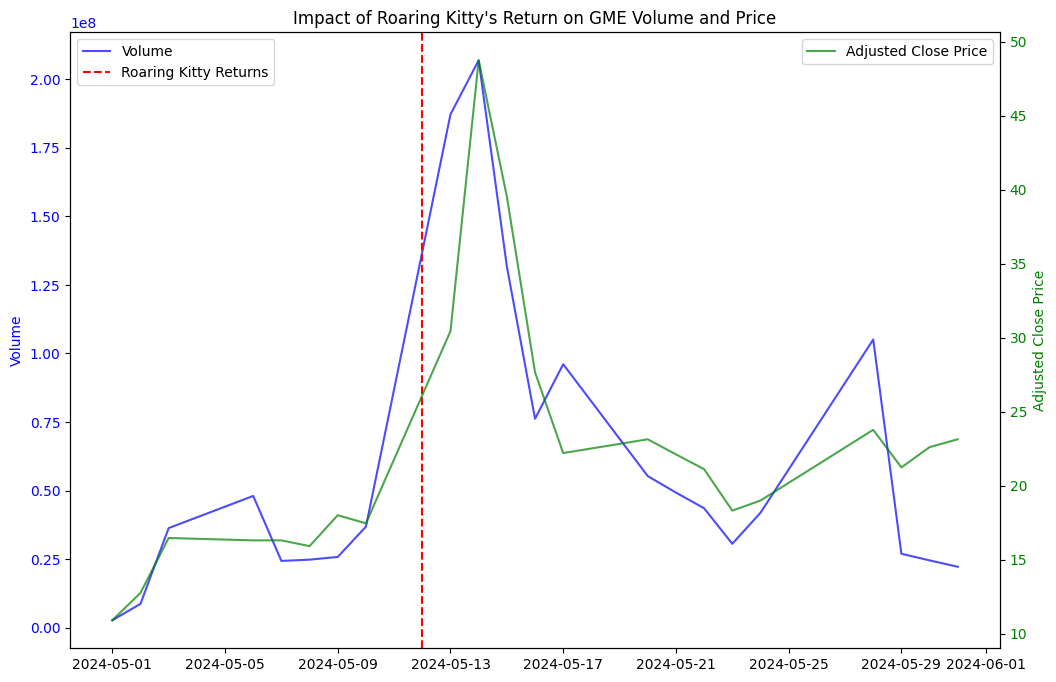

In [67]:
# Convert the event date to a datetime object
event_date = pd.to_datetime('2024-05-12')
event_window = GME_recent_TA.loc[(GME_recent_TA.index >= '2024-05-01') & (GME_recent_TA.index <= '2024-05-31')]
# Plot volume and adjusted close price separately for better visualization
fig, ax1 = plt.subplots(figsize=(12, 8))

# Volume plot
ax1.set_title("Impact of Roaring Kitty's Return on GME Volume and Price")
ax1.plot(event_window.index, event_window['Volume'], label='Volume', color='blue', alpha=0.7)
ax1.axvline(x=event_date, color='red', linestyle='--', label="Roaring Kitty Returns")
ax1.set_ylabel("Volume", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the adjusted close price
ax2 = ax1.twinx()
ax2.plot(event_window.index, event_window['Adj Close'], label='Adjusted Close Price', color='green', alpha=0.7)
ax2.set_ylabel("Adjusted Close Price", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [68]:
# Define the short squeeze period (January to March 2021)
squeeze_start = '2021-01-01'
squeeze_end = '2021-03-31'

# Define the month after Roaring Kitty's return (May 12 to June 12, 2021)
rk_return = '2021-05-12'
rk_end = '2021-06-12'

# Filter out both periods from the entire dataset
filtered_data = GME_recent_TA[
    ~((GME_recent_TA.index >= squeeze_start) & (GME_recent_TA.index <= squeeze_end)) &
    ~((GME_recent_TA.index >= rk_return) & (GME_recent_TA.index <= rk_end))
]

print(f"Original data count: {len(GME_recent_TA)}")
print(f"Filtered data count: {len(filtered_data)}")


Original data count: 1297
Filtered data count: 1214


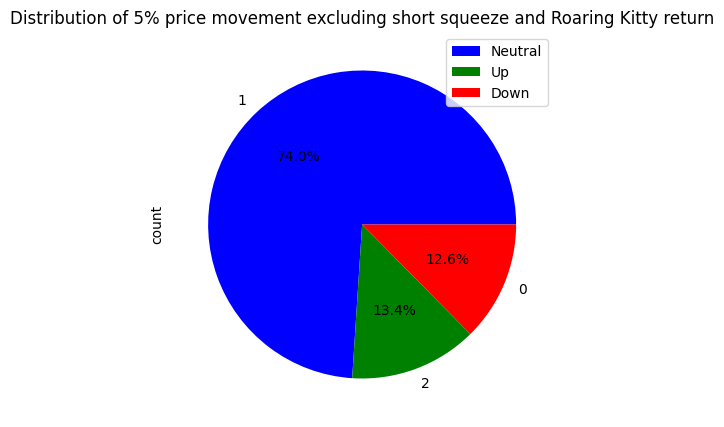

In [69]:
fig, ax = plt.subplots(figsize=(5,5))
filtered_data['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['blue','green','red'])
plt.title('Distribution of 5% price movement excluding short squeeze and Roaring Kitty return')
plt.legend(['Neutral', 'Up','Down'])
plt.show()

## Consider other large events - Earnings

In [70]:
# Load the earnings DataFrame - From AlphaVantage
earnings_df = pd.read_csv('earnings_dates.csv')

# Convert 'earnings_date' to datetime and set as index
earnings_df['earnings_date'] = pd.to_datetime(earnings_df['earnings_date'])
earnings_df.set_index('earnings_date', inplace=True)

# Initialize earnings flag in GME_recent_TA if not already present
if 'earnings_flag' not in GME_recent_TA.columns:
    GME_recent_TA["earnings_flag"] = 0  

# Update GME_recent_TA with earnings_df
# Since both are using dates as indices, you can directly use the update method
GME_recent_TA.update(earnings_df)

# Convert earnings_flag to integer (in case of any NaN values that need to be handled)
GME_recent_TA['earnings_flag'] = GME_recent_TA['earnings_flag'].fillna(0).astype(int)

# Check the result
print(GME_recent_TA[['earnings_flag']].tail(20))


            earnings_flag
Date                     
2025-02-07              0
2025-02-10              0
2025-02-11              0
2025-02-12              0
2025-02-13              0
2025-02-14              0
2025-02-18              0
2025-02-19              0
2025-02-20              0
2025-02-21              0
2025-02-24              0
2025-02-25              0
2025-02-26              0
2025-02-27              0
2025-02-28              0
2025-03-03              0
2025-03-04              0
2025-03-05              0
2025-03-06              0
2025-03-07              0


In [71]:
GME_recent_TA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1297 entries, 2020-01-09 to 2025-03-07
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Adj Close                1297 non-null   float64
 1   Close                    1297 non-null   float64
 2   High                     1297 non-null   float64
 3   Low                      1297 non-null   float64
 4   Open                     1297 non-null   float64
 5   Volume                   1297 non-null   int32  
 6   vwap                     1297 non-null   float64
 7   sma                      1297 non-null   float64
 8   ema                      1297 non-null   float64
 9   bb_middle                1297 non-null   float64
 10  bb_upper                 1297 non-null   float64
 11  bb_lower                 1297 non-null   float64
 12  macd                     1297 non-null   float64
 13  macd_signal              1297 non-null   float64
 14  macd_d

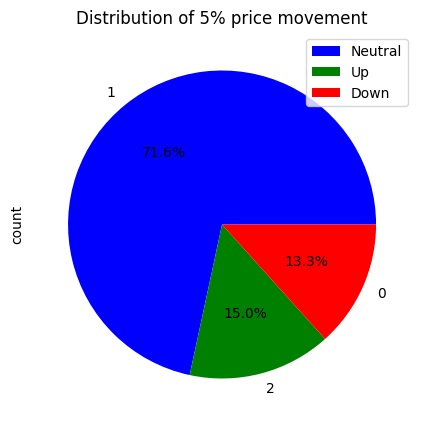

In [72]:
fig, ax = plt.subplots(figsize=(5,5))
GME_recent_TA['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['blue','green','red'])
plt.title('Distribution of 5% price movement')
plt.legend(['Neutral', 'Up','Down'])
plt.show()

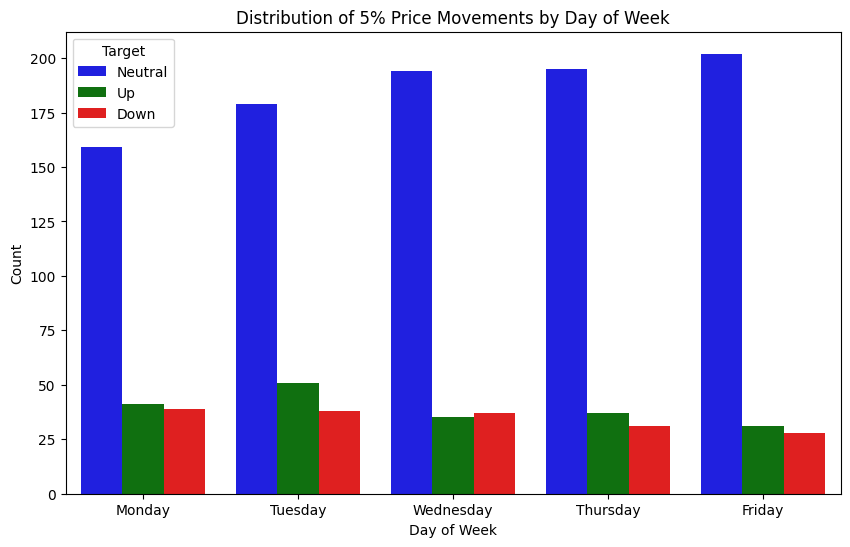

In [73]:
## Visualise the distribution of the movements over the week

plt.figure(figsize=(10, 6))
sns.countplot(
    x='Day_of_Week',
    hue='target',
    data=GME_recent_TA,
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    hue_order=[1, 2, 0],  # Order of the hue categories (Neutral, Up, Down)
    palette={1: 'blue', 2: 'green', 0: 'red'}  # Color mapping for each target value
)
plt.title('Distribution of 5% Price Movements by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Neutral', 'Up', 'Down'])
plt.xticks(rotation=0)
plt.show()

## Create an LSTM Model
Look at a 60 day sequence - medium term as a starting point

In [66]:
## Scale the features 'Adj Close', 'Volume', 'vwap', 'sma', 'ema', 'macd', 'rsi', 'atr', 'Cluster'
features = GME_recent_TA[['Adj Close', 'Volume', 'vwap', 'sma', 'ema', 'macd', 'rsi', 'atr', 'Cluster']].values
scaler = MinMaxScaler()
scaled_recent_features = scaler.fit_transform(features)
# Target - Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
data = scaled_recent_features

In [76]:
# Sequence Creation Function
def create_sequences(data, target, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Create sequence of features
        X.append(data[i:i+time_steps, :])
        # Target is the next time step's classification
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

In [68]:
## Create the independent and dependent variables
X,y =create_sequences(data, target)

In [69]:
## Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X shape: (1241, 60, 9)
y shape: (1241,)
X_train shape: (992, 60, 9)
X_test shape: (249, 60, 9)
y_train shape: (992,)
y_test shape: (249,)


In [71]:

    # Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train )
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [72]:
# Convert target to categorical so softmax activation can be used
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [73]:
# Building the LSTM model - 
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  
])


# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\lynsk\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Dynamic input layer
    LSTM(50, return_sequences=False),  # No explicit input_shape
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print model summary for verification
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,153 (47.47 KB)

 Trainable params: 12,153 (47.47 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Callbacks 

callbacks = [
    EarlyStopping(
        monitor='val_loss',              # Monitor validation loss for improvements
        patience=20,                     # Number of epochs with no improvement
        restore_best_weights=True        # Restore best weights at the end of training
    ),
    ModelCheckpoint(
        'best_model.keras',              # Change the filename to 'best_model.keras'
        monitor='val_accuracy',          # Monitor validation accuracy
        save_best_only=True,             # Save only when the monitored metric has improved
        )
]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6366 - loss: 0.9408 
Test Accuracy: 62.25%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.12      0.15        33
           1       0.75      0.79      0.77       178
           2       0.26      0.26      0.26        38

    accuracy                           0.62       249
   macro avg       0.40      0.39      0.39       249
weighted avg       0.60      0.62      0.61       249



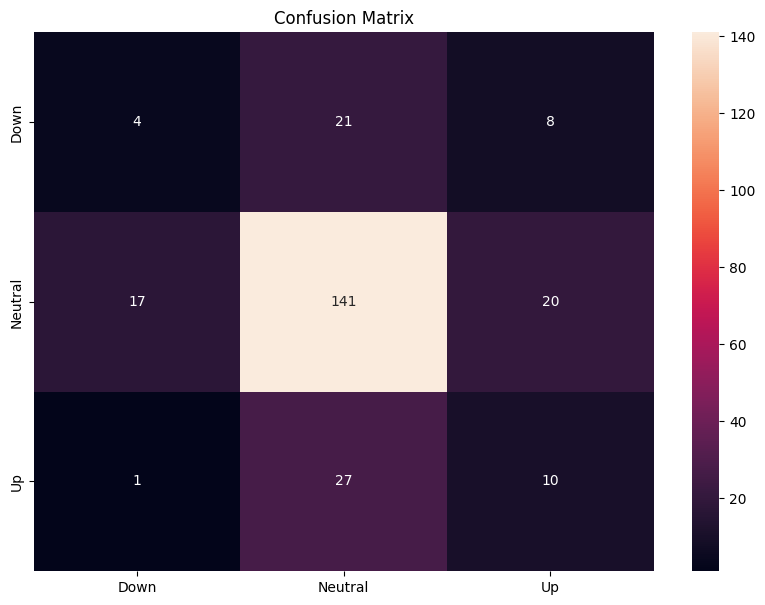

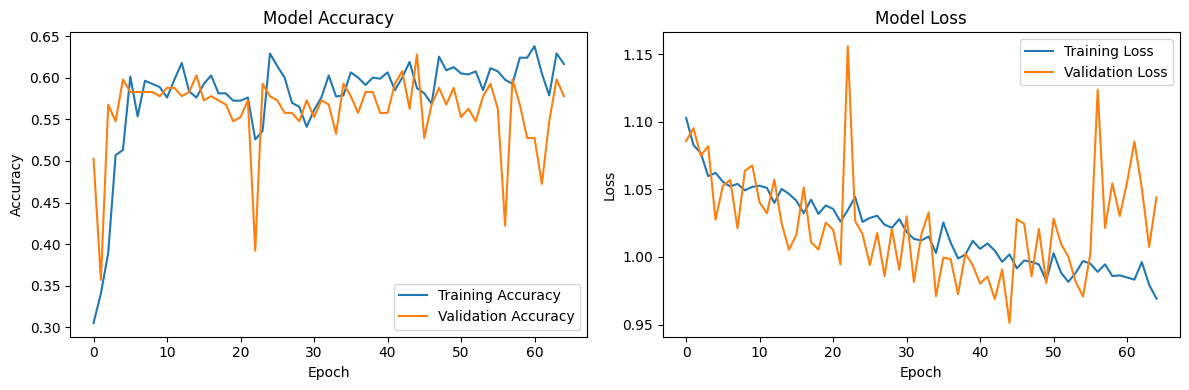

In [76]:

# Train the Model
history = model.fit(
    X_train, y_train_cat,       # Training data
    epochs=100,                 # Maximum number of epochs
    batch_size=32,              # Number of samples per gradient update
    validation_split=0.2,       # Use 20% of training data for validation
    callbacks=callbacks,        # Early stopping and model checkpointing
    class_weight=class_weights_dict,
    verbose=0  # Suppress output        
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)



print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))
target_names = ['Down', 'Neutral', 'Up']
# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels= target_names,
            yticklabels= target_names)
plt.title('Confusion Matrix')
plt.show()

# Training History Visualization
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## TRY MODELLING OVER DIFFERENT TIME PERIODS

In [77]:

# Define lookback periods with a fixed forecast horizon
lookback_periods = [30, 60, 90, 180, 252]

results = {}
best_accuracy = 0
best_model = None
best_period = None

for period in lookback_periods:
    X, y = create_sequences(data, target, time_steps=period)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Calculate class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Convert target to categorical
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)

   
   # Build model with current period
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Ensure the directory for model checkpoints exists
    os.makedirs('model_checkpoints', exist_ok=True)

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ModelCheckpoint(filepath=f'model_checkpoints/best_model_period_{period}.keras', monitor='val_accuracy', save_best_only=True)
    ]

    # Train the model with class weights
    history = model.fit(
        X_train, y_train_cat,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=0  # Suppress output
    )

    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    
    # Store detailed results
    results[period] = {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'history': history.history
    }
    
    print(f"Period {period}: Test Accuracy = {test_accuracy*100:.2f}%")
    
    # Track the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        best_period = period

# Save the best model
if best_model is not None:
    best_model.save(f'model_checkpoints/best_model_overall.keras')
    print(f"\nBest model saved as 'best_model_overall.keras'")


Period 30: Test Accuracy = 65.49%
Period 60: Test Accuracy = 62.25%
Period 90: Test Accuracy = 57.20%
Period 180: Test Accuracy = 68.89%
Period 252: Test Accuracy = 56.67%

Best model saved as 'best_model_overall.keras'


## Confusion Matrix of the best model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


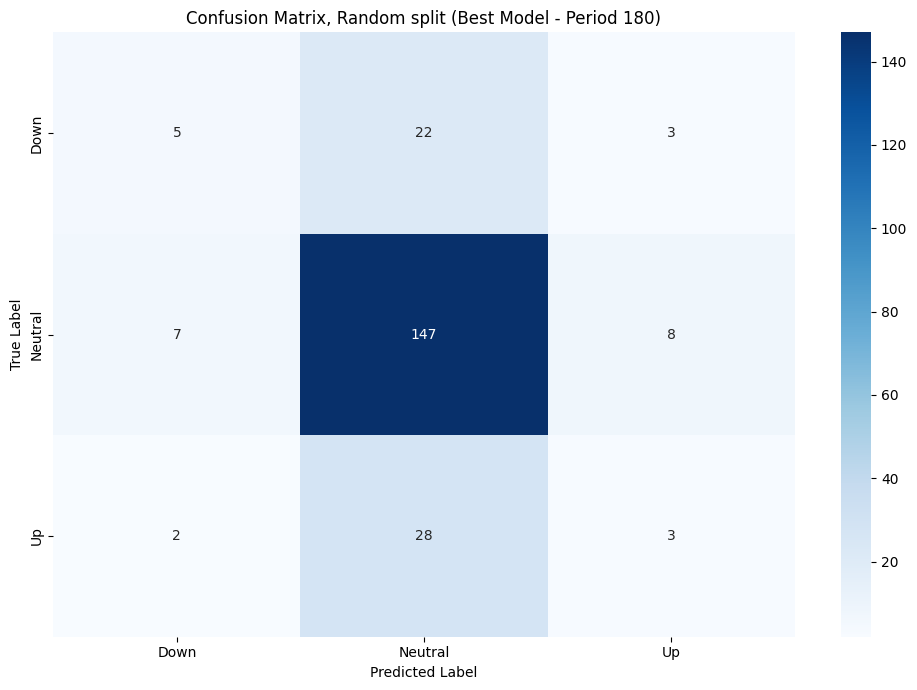


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.36      0.17      0.23        30
     Class 1       0.75      0.91      0.82       162
     Class 2       0.21      0.09      0.13        33

    accuracy                           0.69       225
   macro avg       0.44      0.39      0.39       225
weighted avg       0.62      0.69      0.64       225



In [78]:

# Use the best model and best period
X, y = create_sequences(data, target, time_steps=best_period)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Predict on test data
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(to_categorical(y_test, num_classes=3), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title(f'Confusion Matrix, Random split (Best Model - Period {best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                             target_names=['Class 0', 'Class 1', 'Class 2']))

## Use Timeseries split 

In [79]:
# Define lookback periods with a fixed forecast horizon
ts_lookback_periods = [30, 60, 90, 180, 252]

ts_results = {}
ts_best_accuracy = 0
ts_best_model = None
ts_best_period = None

# Create TimeSeriesSplit
ts_cv = TimeSeriesSplit(n_splits=5)

for period in ts_lookback_periods:
    # Create sequences
    ts_X, ts_y = create_sequences(data, target, time_steps=period)
    
    # Store split results for this period
    ts_split_results = []
    
    # Perform time series cross-validation
    for split, (train_index, test_index) in enumerate(ts_cv.split(ts_X), 1):
        # Split data
        ts_X_train, ts_X_test = ts_X[train_index], ts_X[test_index]
        ts_y_train, ts_y_test = ts_y[train_index], ts_y[test_index]

        # Calculate class distribution
        unique, counts = np.unique(ts_y_train, return_counts=True)
        print(f"Split {split} Class Distribution:", dict(zip(unique, counts)))

        # Compute class weights using sklearn
        ts_class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(ts_y_train),
            y=ts_y_train
        )
        ts_class_weights_dict = {i: ts_class_weights[i] for i in range(len(ts_class_weights))}
        
        # Convert target to categorical
        ts_y_train_cat = to_categorical(ts_y_train, num_classes=3)
        ts_y_test_cat = to_categorical(ts_y_test, num_classes=3)

        # Build model with current period
        ts_model = Sequential([
            Input(shape=(ts_X_train.shape[1], ts_X_train.shape[2])),
            LSTM(50, return_sequences=True),  # Added return_sequences
            LSTM(50, return_sequences=False),  # Additional LSTM layer
            Dropout(0.5),
            Dense(64, activation='relu'),  # Additional dense layer
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

        ts_model.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )

        # Ensure the directory for model checkpoints exists
        os.makedirs('ts_model_checkpoints', exist_ok=True)

        # Define callbacks
        ts_callbacks = [
            EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=f'ts_model_checkpoints/best_model_period_{period}_split_{split}.keras', 
                monitor='val_accuracy', 
                save_best_only=True
            )
        ]

        # Train the model with class weights
        ts_history = ts_model.fit(
            ts_X_train, ts_y_train_cat,
            epochs=100,
            batch_size=32,
            validation_data=(ts_X_test, ts_y_test_cat),
            callbacks=ts_callbacks,
            class_weight=ts_class_weights_dict,
            verbose=0  # Suppress output
        )

        # Evaluate
        ts_test_loss, ts_test_accuracy = ts_model.evaluate(ts_X_test, ts_y_test_cat, verbose=0)
        
        # Store split results
        ts_split_results.append({
            'split': split,
            'accuracy': ts_test_accuracy,
            'loss': ts_test_loss
        })
    
    # Aggregate results for this period
    ts_period_results = pd.DataFrame(ts_split_results)
    avg_accuracy = ts_period_results['accuracy'].mean()
    
    print(f"Period {period}: Average Test Accuracy = {avg_accuracy*100:.2f}%")
    
    # Store results
    ts_results[period] = {
        'split_results': ts_split_results,
        'avg_accuracy': avg_accuracy
    }
    
    # Track the best model
    if avg_accuracy > ts_best_accuracy:
        ts_best_accuracy = avg_accuracy
        ts_best_model = ts_model
        ts_best_period = period

# Save the best model
if ts_best_model is not None:
    ts_best_model.save(f'ts_model_checkpoints/best_model_overall.keras')
    print(f"\nBest model saved as 'best_model_overall.keras'")

# Print detailed results
for period, results in ts_results.items():
    print(f"\nPeriod {period} Results:")
    print(pd.DataFrame(results['split_results']))
    print(f"Average Accuracy: {results['avg_accuracy']*100:.2f}%")

Split 1 Class Distribution: {0: 34, 1: 137, 2: 45}
Split 2 Class Distribution: {0: 68, 1: 272, 2: 87}
Split 3 Class Distribution: {0: 107, 1: 405, 2: 126}
Split 4 Class Distribution: {0: 134, 1: 560, 2: 155}
Split 5 Class Distribution: {0: 149, 1: 743, 2: 168}
Period 30: Average Test Accuracy = 56.87%
Split 1 Class Distribution: {0: 32, 1: 129, 2: 50}
Split 2 Class Distribution: {0: 63, 1: 269, 2: 85}
Split 3 Class Distribution: {0: 103, 1: 399, 2: 121}
Split 4 Class Distribution: {0: 128, 1: 553, 2: 148}
Split 5 Class Distribution: {0: 143, 1: 729, 2: 163}
Period 60: Average Test Accuracy = 53.69%
Split 1 Class Distribution: {0: 34, 1: 123, 2: 49}
Split 2 Class Distribution: {0: 62, 1: 266, 2: 79}
Split 3 Class Distribution: {0: 98, 1: 396, 2: 114}
Split 4 Class Distribution: {0: 121, 1: 549, 2: 139}
Split 5 Class Distribution: {0: 138, 1: 716, 2: 156}
Period 90: Average Test Accuracy = 49.55%
Split 1 Class Distribution: {0: 38, 1: 99, 2: 54}
Split 2 Class Distribution: {0: 63, 1: 239

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


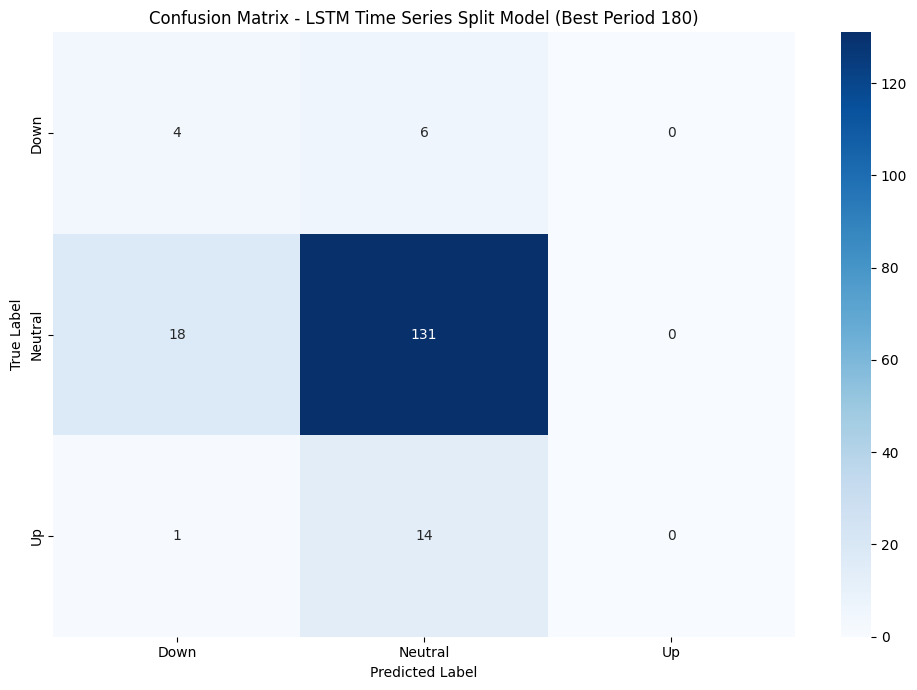


Classification Report:
              precision    recall  f1-score   support

        Down       0.17      0.40      0.24        10
     Neutral       0.87      0.88      0.87       149
          Up       0.00      0.00      0.00        15

    accuracy                           0.78       174
   macro avg       0.35      0.43      0.37       174
weighted avg       0.75      0.78      0.76       174



c:\Users\lynsk\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lynsk\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lynsk\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
# Predict on test data
y_pred_ts = ts_best_model.predict(ts_X_test)
y_pred_ts_classes = np.argmax(y_pred_ts, axis=1)
y_true_ts_classes = np.argmax(to_categorical(ts_y_test, num_classes=3), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_ts_classes, y_pred_ts_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
plt.title(f'Confusion Matrix - LSTM Time Series Split Model (Best Period {ts_best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_ts_classes, y_pred_ts_classes, 
                             target_names=['Down', 'Neutral', 'Up']))

## testing different feature combinations - basic train test split 

In [81]:
## Scale the features - added in to code below for testing
basic_features = GME_recent_TA[['Adj Close', 'Volume','Open']].values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_basic_features = scaler.fit_transform(basic_features)
# Target - Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
basic_data = scaled_basic_features

In [82]:

GME_recent_TA['HLC3'] = (GME_recent_TA['High'] + GME_recent_TA['Low'] + GME_recent_TA['Close']) / 3


#OBV
obv_indicator = OnBalanceVolumeIndicator(close=GME_TA['Close'], volume=GME_TA['Volume'])
GME_recent_TA['obv'] = obv_indicator.on_balance_volume()


# VPT 
GME_recent_TA['vpt'] = (GME_TA['Volume'] * ((GME_TA['Close'] - GME_TA['Close'].shift(1)) / GME_TA['Close'].shift(1))).cumsum()



In [83]:
## Scale the features # 'bb_upper','bb_middle','bb_lower''High','Low','Open','Close', 'vwap'
basic_features = GME_recent_TA[['Adj Close', 'Volume', 'vwap', 'sma', 'ema', 'macd', 'rsi', 'atr', 'Cluster','obv','price_movement',
                                'bb_upper','bb_middle','bb_lower','High','Low','Open','Close', 'HLC3']]
scaled_basic_features = scaler.fit_transform(basic_features)
# Target - Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
basic_data = scaled_basic_features

# Define lookback periods with a fixed forecast horizon
lookback_periods = [3, 5, 10, 15, 20, 90, 180, 252]

basic_results = {}
basic_best_accuracy = 0
basic_best_model = None
basic_best_period = None
# Assuming earlier definitions...
for period in lookback_periods:
    X, y = create_sequences(basic_data, target, time_steps=period)
    X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_basic),
        y=y_train_basic
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    y_train_basic_cat = to_categorical(y_train_basic, num_classes=3)
    y_test_basic_cat = to_categorical(y_test_basic, num_classes=3)
   
    model = Sequential([
        Input(shape=(X_train_basic.shape[1], X_train_basic.shape[2])),
        LSTM(50, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ModelCheckpoint(filepath=f'model_checkpoints/best_model_period_{period}.keras', monitor='val_accuracy', save_best_only=True)
    ]
    
    history = model.fit(
        X_train_basic, y_train_basic_cat,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=0
    )

    test_loss, test_accuracy = model.evaluate(X_test_basic, y_test_basic_cat, verbose=0)
    basic_results[period] = {'accuracy': test_accuracy, 'loss': test_loss, 'history': history.history}
    print(f"Period {period}: Test Accuracy = {test_accuracy*100:.2f}%")
    
    if test_accuracy > basic_best_accuracy:
        basic_best_accuracy = test_accuracy
        basic_best_model = model
        basic_best_period = period

if basic_best_model is not None:
    basic_best_model.save(f'model_checkpoints/best_model_overall.keras')
    print(f"\nBest model saved as 'best_model_overall.keras'")


Period 3: Test Accuracy = 51.92%
Period 5: Test Accuracy = 48.08%
Period 10: Test Accuracy = 54.83%
Period 15: Test Accuracy = 59.30%
Period 20: Test Accuracy = 58.75%
Period 90: Test Accuracy = 47.33%
Period 180: Test Accuracy = 66.22%
Period 252: Test Accuracy = 56.19%

Best model saved as 'best_model_overall.keras'


In [84]:
print(basic_best_model)  # Check if it contains a model


<Sequential name=sequential_38, built=True>


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


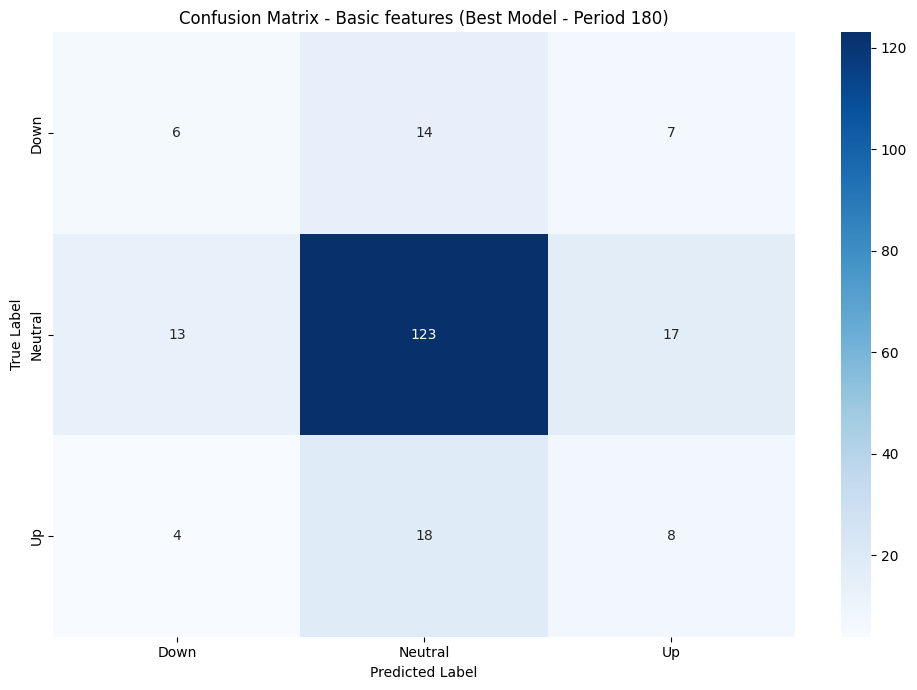


Classification Report:
              precision    recall  f1-score   support

        Down       0.26      0.22      0.24        27
     Neutral       0.79      0.80      0.80       153
          Up       0.25      0.27      0.26        30

    accuracy                           0.65       210
   macro avg       0.43      0.43      0.43       210
weighted avg       0.65      0.65      0.65       210



In [85]:
# Predict on test data
y_pred_basic = basic_best_model.predict(X_test_basic)
y_pred_basic = np.argmax(y_pred_basic, axis=1)
y_true_basic = np.argmax(to_categorical(y_test_basic, num_classes=3), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_basic, y_pred_basic)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
plt.title(f'Confusion Matrix - Basic features (Best Model - Period {basic_best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_true_basic, y_pred_basic, 
                             target_names=['Down', 'Neutral', 'Up']))

## Time series split on same features

In [86]:
## Scale the features 
diff_features = GME_recent_TA[['Adj Close', 'Volume', 'vwap', 'sma', 'ema', 'macd', 'rsi', 'atr', 'Cluster','obv','price_movement',
                                'bb_upper','bb_middle','bb_lower','High','Low','Open','Close', 'HLC3']]
scaled_diff_features = scaler.fit_transform(diff_features)
# Target - Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
diff_data = scaled_diff_features

# Define lookback periods with a fixed forecast horizon
diff_lookback_periods = [3, 5, 10, 15, 20, 30, 60, 90, 180, 252]

# Create TimeSeriesSplit
diff_cv = TimeSeriesSplit(n_splits=5)

diff_results = {}
diff_best_accuracy = 0
diff_best_model = None
diff_best_period = None

for period in diff_lookback_periods:
    # Create sequences
    diff_X, diff_y = create_sequences(diff_data, target, time_steps=period)
    
    # Store split results for this period
    diff_split_results = []
    
    # Perform time series cross-validation
    for split, (train_index, test_index) in enumerate(diff_cv.split(diff_X), 1):
        # Split data
        diff_X_train, diff_X_test = diff_X[train_index], diff_X[test_index]
        diff_y_train, diff_y_test = diff_y[train_index], diff_y[test_index]

        # Calculate class weights
        diff_class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(diff_y_train),
            y=diff_y_train
        )
        diff_class_weights_dict = {i: diff_class_weights[i] for i in range(len(diff_class_weights))}
        
        # Convert target to categorical
        diff_y_train_cat = to_categorical(diff_y_train, num_classes=3)
        diff_y_test_cat = to_categorical(diff_y_test, num_classes=3)

        # Build model with current period
        diff_model = Sequential([
            Input(shape=(diff_X_train.shape[1], diff_X_train.shape[2])),
            LSTM(50, return_sequences=False),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])

        diff_model.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )

        # Ensure the directory for model checkpoints exists
        os.makedirs('model_checkpoints', exist_ok=True)

        # Define callbacks
        diff_callbacks = [
            EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=f'model_checkpoints/best_model_period_{period}_split_{split}.keras', 
                monitor='val_accuracy', 
                save_best_only=True
            )
        ]

        # Train the model with class weights
        diff_history = diff_model.fit(
            diff_X_train, diff_y_train_cat,
            epochs=100,
            batch_size=32,
            validation_data=(diff_X_test, diff_y_test_cat),
            callbacks=diff_callbacks,
            class_weight=diff_class_weights_dict,
            verbose=0  # Suppress output
        )

        # Evaluate
        diff_test_loss, diff_test_accuracy = diff_model.evaluate(diff_X_test, diff_y_test_cat, verbose=0)
        
        # Store split results
        diff_split_results.append({
            'split': split,
            'accuracy': diff_test_accuracy,
            'loss': diff_test_loss
        })
    
    # Aggregate results for this period
    diff_period_results = pd.DataFrame(diff_split_results)
    avg_accuracy = diff_period_results['accuracy'].mean()
    
    print(f"Period {period}: Average Test Accuracy = {avg_accuracy*100:.2f}%")
    
    # Store results
    diff_results[period] = {
        'split_results': diff_split_results,
        'avg_accuracy': avg_accuracy
    }
    
    # Track the best model
    if avg_accuracy > diff_best_accuracy:
        diff_best_accuracy = avg_accuracy
        diff_best_model = diff_model
        diff_best_period = period

# Save the best model
if diff_best_model is not None:
    diff_best_model.save(f'model_checkpoints/best_model_overall.keras')
    print(f"\nBest model saved as 'best_model_overall.keras'")

# Print detailed results
for period, results in diff_results.items():
    print(f"\nPeriod {period} Results:")
    print(pd.DataFrame(results['split_results']))
    print(f"Average Accuracy: {results['avg_accuracy']*100:.2f}%")

Period 3: Average Test Accuracy = 64.17%
Period 5: Average Test Accuracy = 57.96%
Period 10: Average Test Accuracy = 56.09%
Period 15: Average Test Accuracy = 65.51%
Period 20: Average Test Accuracy = 70.80%
Period 30: Average Test Accuracy = 62.84%
Period 60: Average Test Accuracy = 59.03%
Period 90: Average Test Accuracy = 63.68%
Period 180: Average Test Accuracy = 61.18%
Period 252: Average Test Accuracy = 47.82%

Best model saved as 'best_model_overall.keras'

Period 3 Results:
   split  accuracy      loss
0      1  0.259259  1.119039
1      2  0.629630  0.974122
2      3  0.699074  1.055044
3      4  0.847222  0.761044
4      5  0.773148  0.756422
Average Accuracy: 64.17%

Period 5 Results:
   split  accuracy      loss
0      1  0.189815  1.132877
1      2  0.638889  0.962993
2      3  0.490741  1.083890
3      4  0.810185  0.711454
4      5  0.768519  0.734390
Average Accuracy: 57.96%

Period 10 Results:
   split  accuracy      loss
0      1  0.162791  1.254228
1      2  0.604651

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


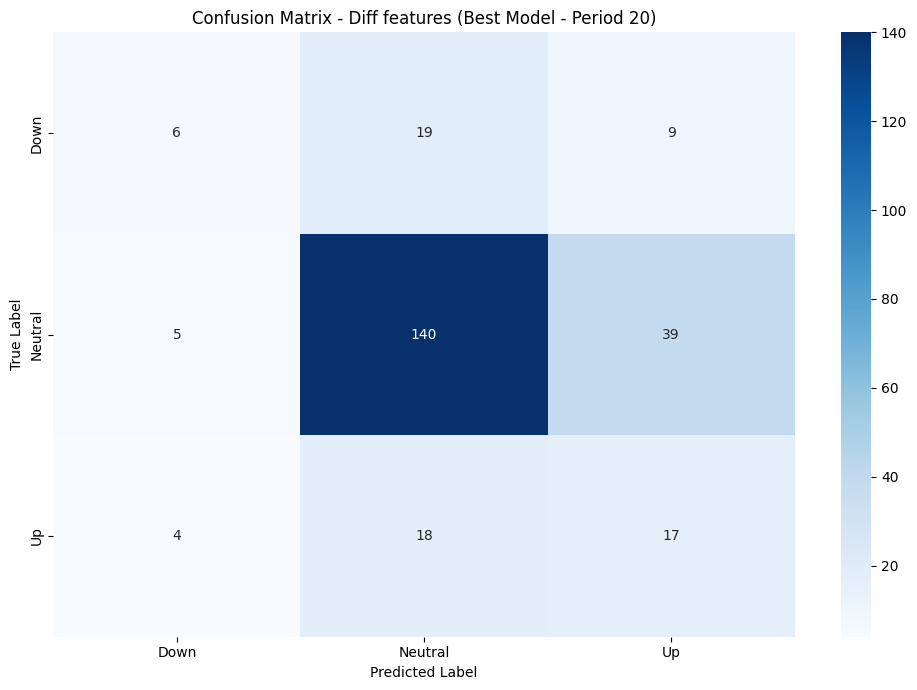


Classification Report:
              precision    recall  f1-score   support

        Down       0.40      0.18      0.24        34
     Neutral       0.79      0.76      0.78       184
          Up       0.26      0.44      0.33        39

    accuracy                           0.63       257
   macro avg       0.48      0.46      0.45       257
weighted avg       0.66      0.63      0.64       257



In [87]:
# Recreate sequences for the best period
diff_X, diff_y = create_sequences(diff_data, target, time_steps=diff_best_period)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    diff_X, diff_y, 
    test_size=0.2, 
    random_state=42, 
    stratify=diff_y
)
# Predict on test data
y_pred_diff = diff_best_model.predict(X_test)
y_pred_diff = np.argmax(y_pred_diff, axis=1)
y_true_diff = np.argmax(to_categorical(y_test, num_classes=3), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_diff, y_pred_diff)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
plt.title(f'Confusion Matrix - Diff features (Best Model - Period {diff_best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_true_diff, y_pred_diff, 
                             target_names=['Down', 'Neutral', 'Up']))

## All the numeric features

In [74]:
# Create a copy of only the numeric columns
GME_numeric = GME_recent_TA.select_dtypes(include=['number']).copy()
print(GME_numeric.head())


            Adj Close   Close    High     Low    Open    Volume      vwap  \
Date                                                                        
2020-01-09     1.3875  1.3875  1.4550  1.3700  1.4550  10572000  1.458327   
2020-01-10     1.3575  1.3575  1.4000  1.3450  1.3900  11125600  1.449954   
2020-01-13     1.3575  1.3575  1.4025  1.3325  1.3575  14500800  1.439765   
2020-01-14     1.1775  1.1775  1.2500  1.1325  1.1950  50247600  1.395634   
2020-01-15     1.1525  1.1525  1.1825  1.1375  1.1650  19924400  1.380141   

                 sma       ema  bb_middle  ...           vpt  price_movement  \
Date                                       ...                                 
2020-01-09  1.446500  1.460352   1.446500  ... -1.636946e+08       -0.029720   
2020-01-10  1.445250  1.450557   1.445250  ... -1.639351e+08       -0.021622   
2020-01-13  1.443375  1.441694   1.443375  ... -1.639351e+08        0.000000   
2020-01-14  1.434125  1.416533   1.434125  ... -1.705978e+08

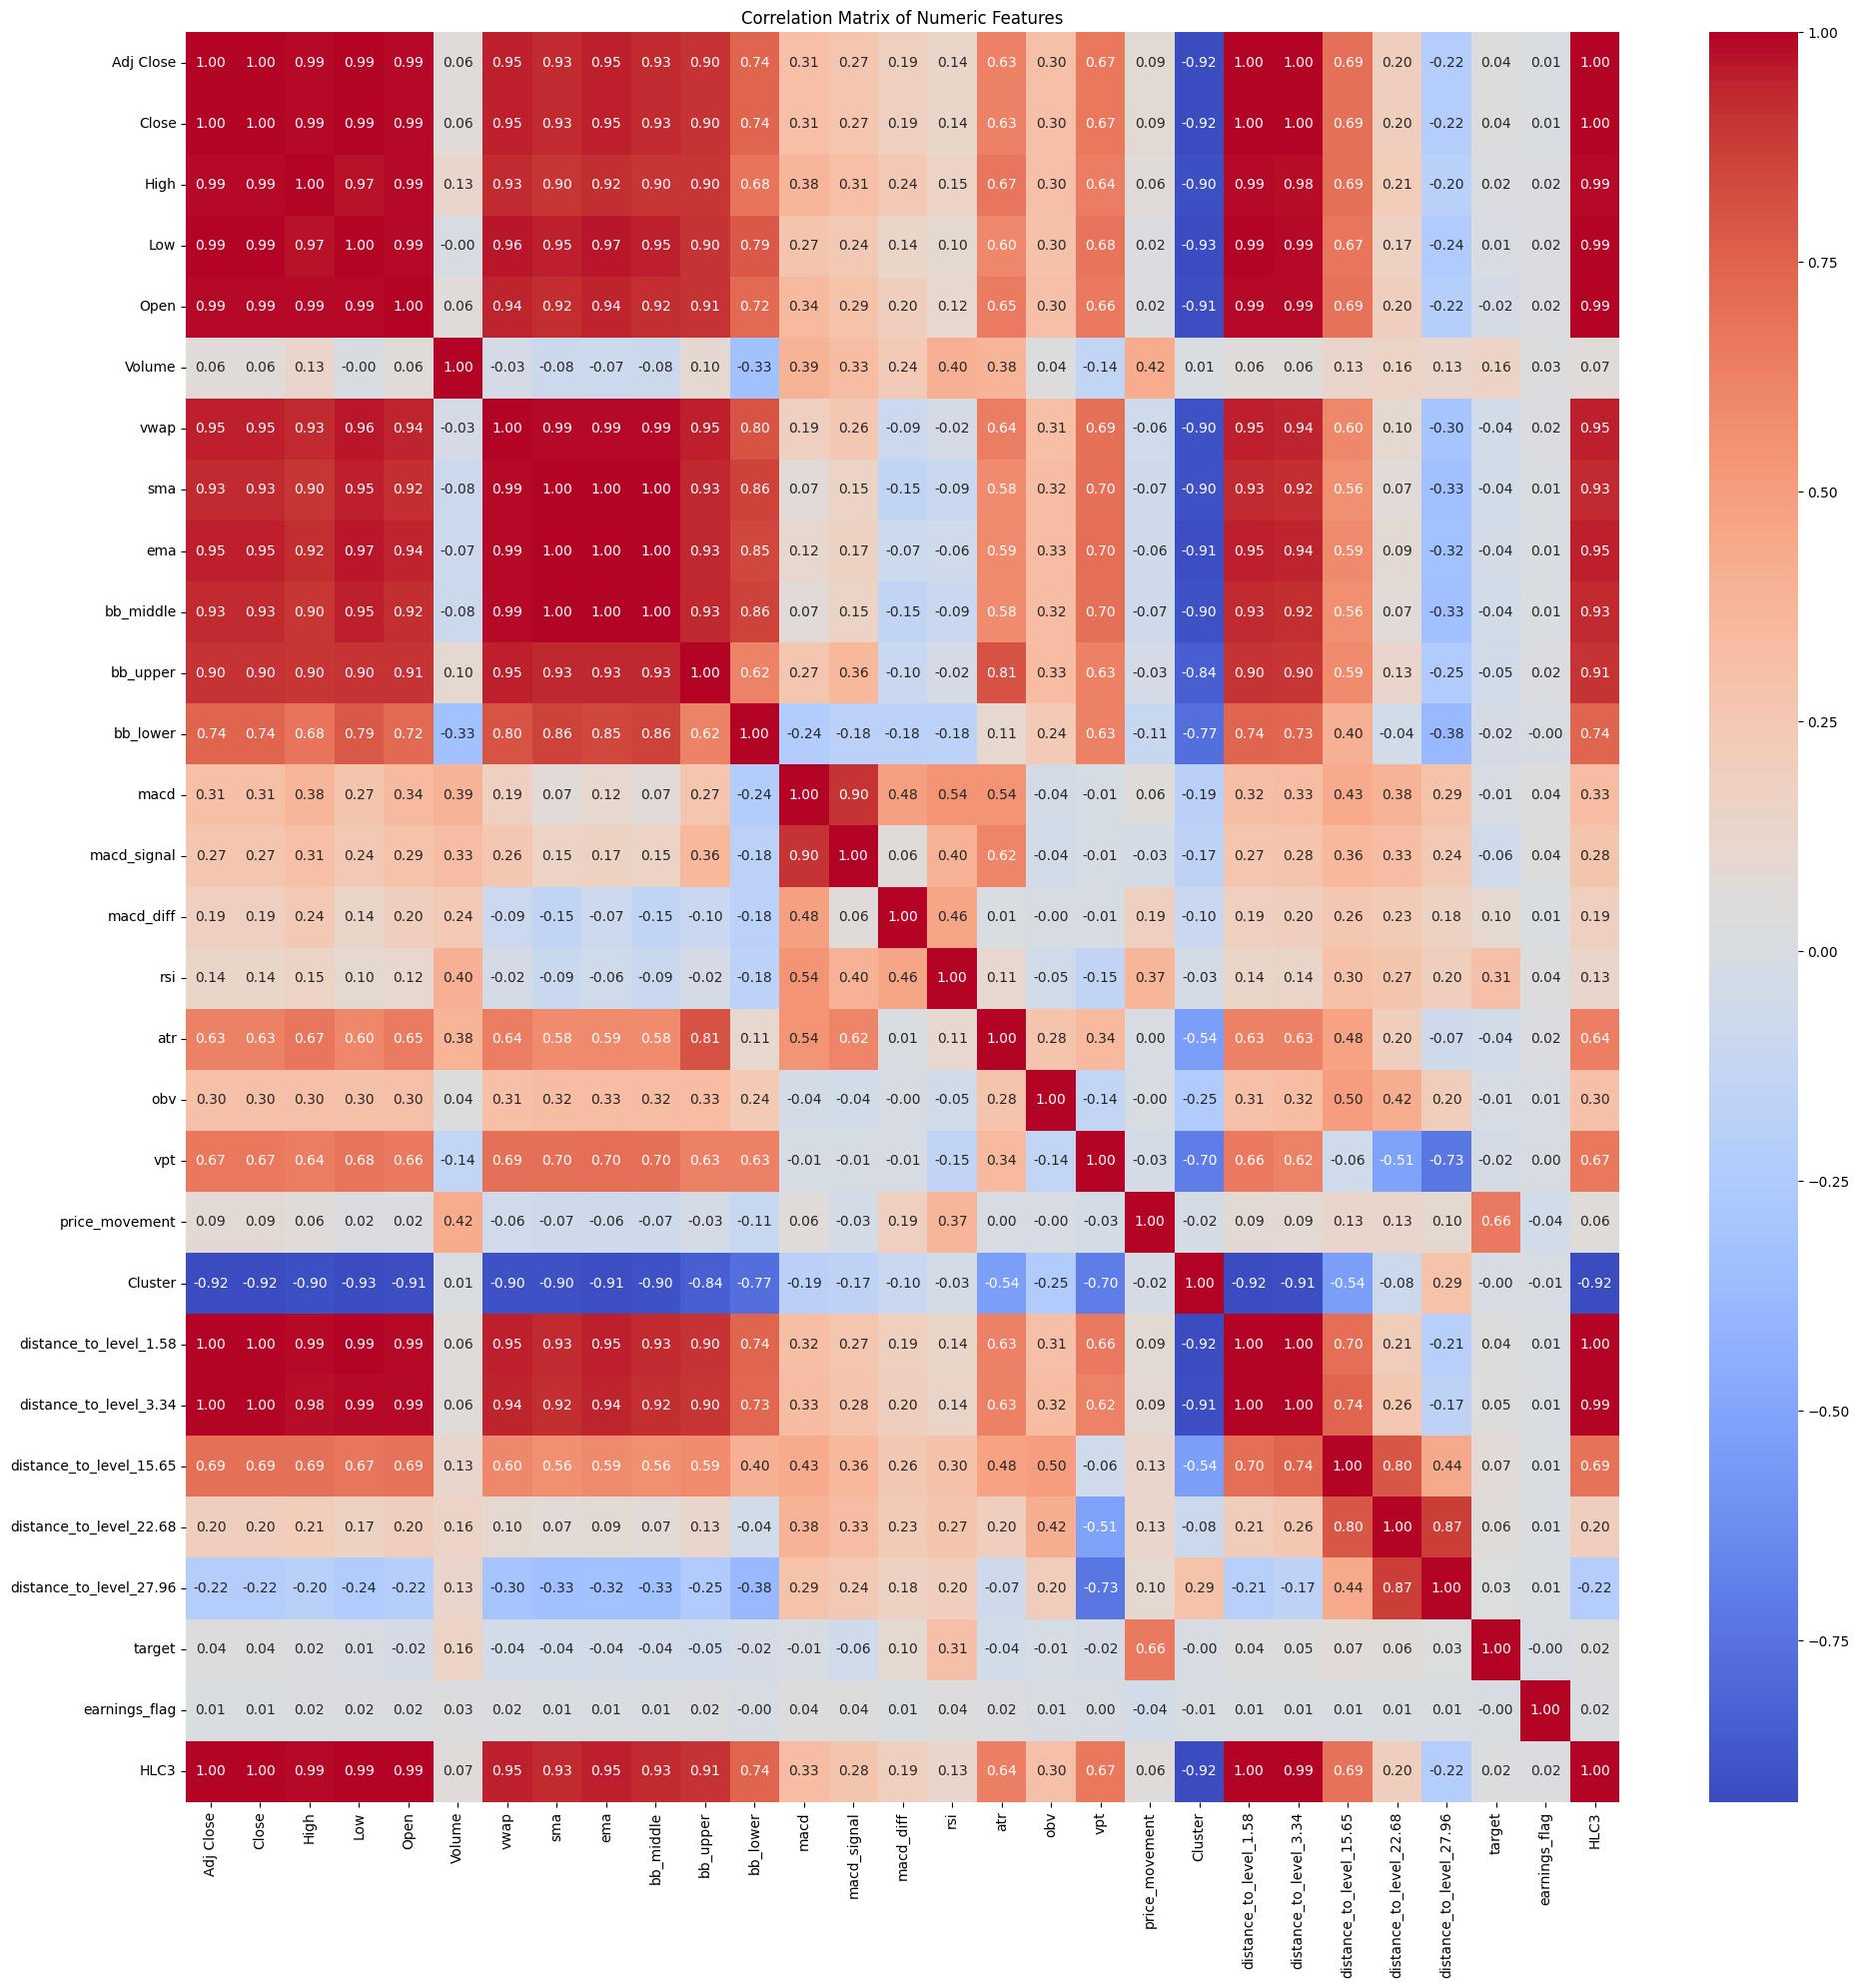

In [89]:
# Look at TA's that correlate with target
#numeric_columns = GME_recent_TA.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = GME_numeric.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

In [90]:
# Create a copy of the dataframe without the target - normal test train split 
all_df = GME_numeric.drop('target', axis=1)

# Scale the features 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_all = scaler.fit_transform(all_df)

# Target - Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
all_data = scaled_all
# Define lookback periods with a fixed forecast horizon
lookback_periods = [3, 5,10, 20, 30, 60, 90, 180, 252]

all_results = {}
all_best_accuracy = 0
all_best_model = None
all_best_period = None

# Assuming earlier definitions...
for period in lookback_periods:
    X, y = create_sequences(all_data, target, time_steps=period)
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_all),
        y=y_train_all
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    y_train_all_cat = to_categorical(y_train_all, num_classes=3)
    y_test_all_cat = to_categorical(y_test_all, num_classes=3)
   
    model = Sequential([
        Input(shape=(X_train_all.shape[1], X_train_all.shape[2])),
        LSTM(50, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ModelCheckpoint(filepath=f'model_checkpoints/best_model_period_{period}.keras', monitor='val_accuracy', save_best_only=True)
    ]
    
    history = model.fit(
        X_train_all, y_train_all_cat,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=0
    )

    test_loss, test_accuracy = model.evaluate(X_test_all, y_test_all_cat, verbose=0)
    all_results[period] = {'accuracy': test_accuracy, 'loss': test_loss, 'history': history.history}
    print(f"Period {period}: Test Accuracy = {test_accuracy*100:.2f}%")
    
    if test_accuracy > all_best_accuracy:
        all_best_accuracy = test_accuracy
        all_best_model = model
        all_best_period = period

if all_best_model is not None:
    all_best_model.save(f'model_checkpoints/best_model_overall.keras')
    print(f"\nBest model saved as 'best_model_overall.keras'")

Period 3: Test Accuracy = 54.23%
Period 5: Test Accuracy = 50.77%
Period 10: Test Accuracy = 54.44%
Period 20: Test Accuracy = 48.64%
Period 30: Test Accuracy = 63.53%
Period 60: Test Accuracy = 60.24%
Period 90: Test Accuracy = 51.44%
Period 180: Test Accuracy = 72.89%
Period 252: Test Accuracy = 56.67%

Best model saved as 'best_model_overall.keras'


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


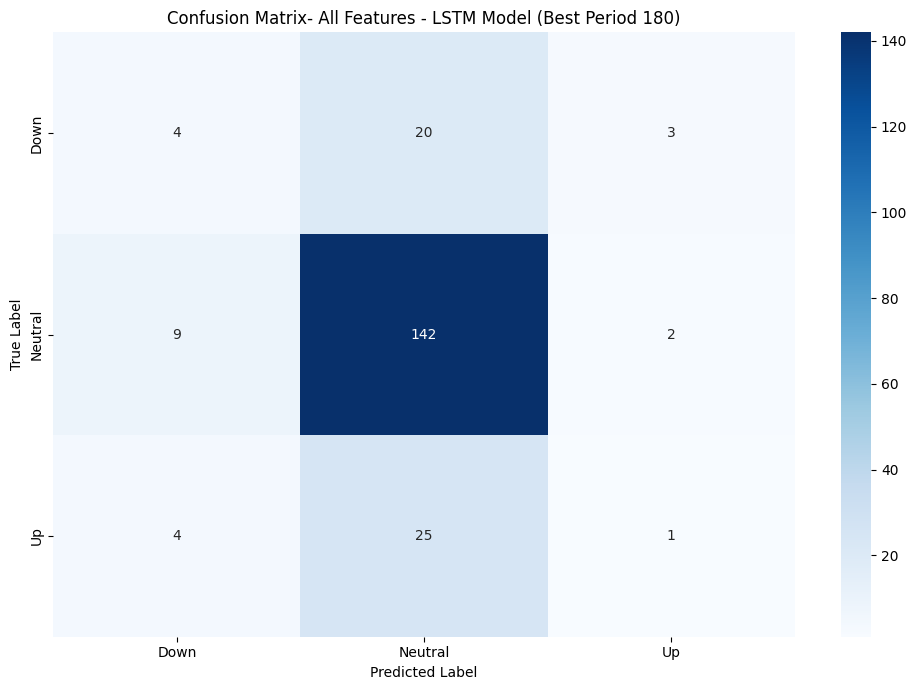


Classification Report:
              precision    recall  f1-score   support

        Down       0.24      0.15      0.18        27
     Neutral       0.76      0.93      0.84       153
          Up       0.17      0.03      0.06        30

    accuracy                           0.70       210
   macro avg       0.39      0.37      0.36       210
weighted avg       0.61      0.70      0.64       210



In [91]:
#Visualise the model using all the numeric data
#  Predict on test data
y_pred_all = all_best_model.predict(X_test_all)
y_pred_all_classes = np.argmax(y_pred_all, axis=1)
y_true_all_classes = np.argmax(y_test_all_cat, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_all_classes, y_pred_all_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
plt.title(f'Confusion Matrix- All Features - LSTM Model (Best Period {all_best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_true_all_classes, y_pred_all_classes, 
                             target_names=['Down', 'Neutral', 'Up']))

## Time Series split on all features

In [81]:
# Create a copy of the dataframe without the target
all_df = GME_numeric.drop('target', axis=1)

# Scale the features 
scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled_all = scaler.fit_transform(all_df)

# Target - Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
ts_all_data = ts_scaled_all## Scale the features 


# Define lookback periods with a fixed forecast horizon
ts_all_lookback_periods = [30, 60, 90, 180, 252]

# Create TimeSeriesSplit
ts_all_cv = TimeSeriesSplit(n_splits=5)

ts_all_results = {}
ts_all_best_accuracy = 0
ts_all_best_model = None
ts_all_best_period = None

for period in ts_all_lookback_periods:
    ts_all_X, ts_all_y = create_sequences(ts_all_data, target, time_steps=period)
    
    # Store split results for this period
    ts_all_split_results = []
    
    # Perform time series cross-validation
    for split, (train_index, test_index) in enumerate(ts_all_cv.split(ts_all_X), 1):
        # Split data
        ts_all_X_train, ts_all_X_test = ts_all_X[train_index], ts_all_X[test_index]
        ts_all_y_train, ts_all_y_test = ts_all_y[train_index], ts_all_y[test_index]

        # Calculate class weights
        ts_all_class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(ts_all_y_train),
            y=ts_all_y_train
        )
        ts_all_class_weights_dict = {i: ts_all_class_weights[i] for i in range(len(ts_all_class_weights))}
        
        ts_all_y_train_cat = to_categorical(ts_all_y_train, num_classes=3)
        ts_all_y_test_cat = to_categorical(ts_all_y_test, num_classes=3)
   
        model = Sequential([
            Input(shape=(ts_all_X_train.shape[1], ts_all_X_train.shape[2])),
            LSTM(50, return_sequences=False),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        ts_all_callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ModelCheckpoint(filepath=f'model_checkpoints/best_model_period_{period}.keras', monitor='val_accuracy', save_best_only=True)
        ]
    
        history = model.fit(
            ts_all_X_train, ts_all_y_train_cat,
            epochs=100,
            batch_size=32,
            validation_data=(ts_all_X_test, ts_all_y_test_cat),
            callbacks=ts_all_callbacks,
            class_weight=ts_all_class_weights_dict,
            verbose=0
        )

        ts_all_test_loss, ts_all_test_accuracy = model.evaluate(ts_all_X_test, ts_all_y_test_cat, verbose=0)
        ts_all_split_results.append({
            'split': split,
            'accuracy': ts_all_test_accuracy,
            'loss': ts_all_test_loss
        })
    
    # Aggregate results for this period
    ts_all_period_results = pd.DataFrame(ts_all_split_results)
    avg_accuracy = ts_all_period_results['accuracy'].mean()
    
    print(f"Period {period}: Average Test Accuracy = {avg_accuracy*100:.2f}%")
    
    ts_all_results[period] = {
        'split_results': ts_all_split_results,
        'avg_accuracy': avg_accuracy
    }
    
    if avg_accuracy > ts_all_best_accuracy:
        ts_all_best_accuracy = avg_accuracy
        ts_all_best_model = model
        ts_all_best_period = period

if ts_all_best_model is not None:
    ts_all_best_model.save(f'model_checkpoints/ts_all_best_model_overall.keras')
    print(f"\nBest model saved as 'ts_all_best_model_overall.keras'")

Period 30: Average Test Accuracy = 55.83%
Period 60: Average Test Accuracy = 57.48%
Period 90: Average Test Accuracy = 55.82%
Period 180: Average Test Accuracy = 58.92%
Period 252: Average Test Accuracy = 48.97%

Best model saved as 'ts_all_best_model_overall.keras'


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


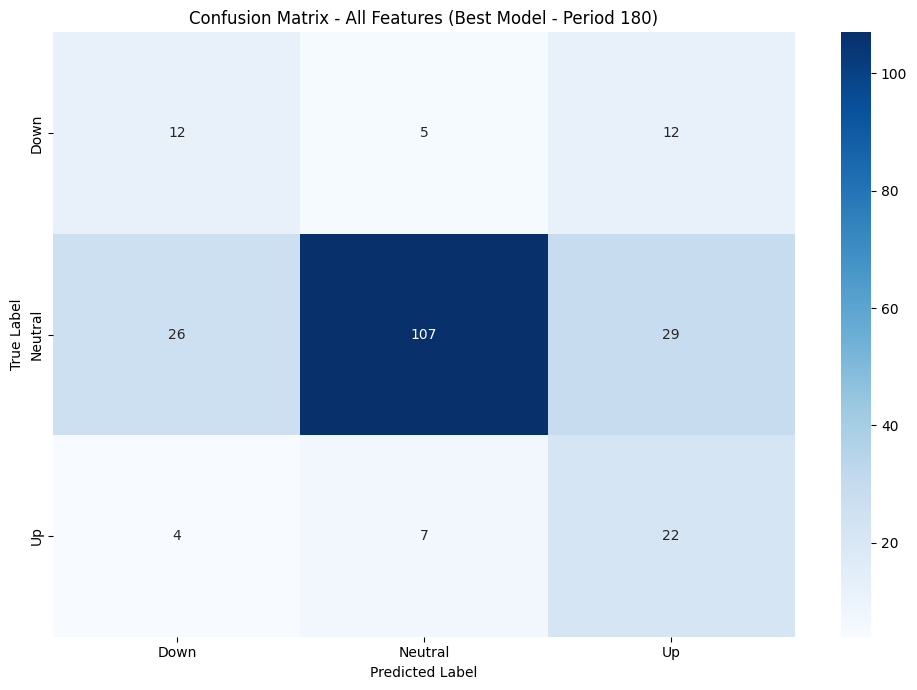


Classification Report:
              precision    recall  f1-score   support

        Down       0.29      0.41      0.34        29
     Neutral       0.90      0.66      0.76       162
          Up       0.35      0.67      0.46        33

    accuracy                           0.63       224
   macro avg       0.51      0.58      0.52       224
weighted avg       0.74      0.63      0.66       224



In [82]:
# Recreate sequences for the best period ** MODEL TO USE**
ts_all_X, ts_all_y = create_sequences(ts_all_data, target, time_steps=ts_all_best_period)

# Split the data
ts_all_X_train, ts_all_X_test, ts_all_y_train, ts_all_y_test = train_test_split(
    ts_all_X, ts_all_y, 
    test_size=0.2, 
    random_state=42, 
    stratify=ts_all_y
)

# Predict on test data
ts_all_y_pred = ts_all_best_model.predict(ts_all_X_test)
ts_all_y_pred_classes = np.argmax(ts_all_y_pred, axis=1)
ts_all_y_true_classes = np.argmax(to_categorical(ts_all_y_test, num_classes=3), axis=1)

# Create confusion matrix
ts_all_cm = confusion_matrix(ts_all_y_true_classes, ts_all_y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(ts_all_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
plt.title(f'Confusion Matrix - All Features (Best Model - Period {ts_all_best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(ts_all_y_true_classes, ts_all_y_pred_classes, 
                             target_names=['Down', 'Neutral', 'Up']))

## Look at the same model with a PCA for all the features

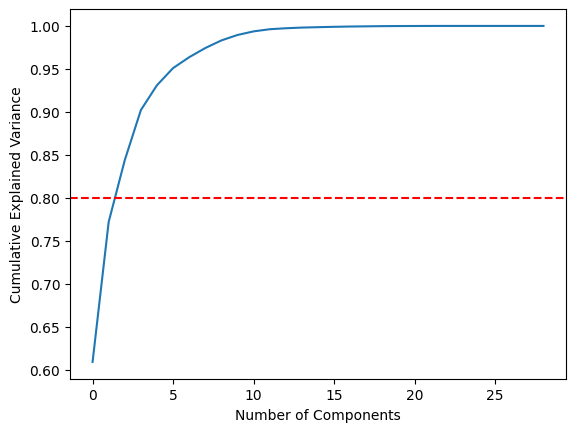

In [94]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(GME_numeric)
pca = PCA().fit(scaled_all)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.show()

In [95]:
print("Variance explained by each component:")
print(pca.explained_variance_ratio_)

Variance explained by each component:
[6.09324763e-01 1.62797531e-01 7.18271330e-02 5.82631196e-02
 2.88511303e-02 1.99299222e-02 1.26354140e-02 1.06751729e-02
 8.84879311e-03 6.32838502e-03 4.17755108e-03 2.49947834e-03
 1.13932809e-03 7.72281226e-04 4.76499757e-04 4.16305284e-04
 3.42185177e-04 2.18817978e-04 2.15307797e-04 1.25334633e-04
 5.54750788e-05 4.93713491e-05 2.98312334e-05 8.68821155e-07
 8.92408009e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


## PCA LSTM MODEL

In [96]:
## Scale the features 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(GME_numeric)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)  
pca_all = pca.fit_transform(scaled_all)

# Calculate the explained variance ratio 
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f'Total Explained Variance by PCA: {explained_variance:.2%}')

# Looking to predict if the price will go up or down by 5%
target = GME_recent_TA['target'].values
pca_ts_data = pca_all  

# Define lookback periods with a fixed forecast horizon
pca_ts_lookback_periods = [5, 10, 20, 30, 60, 90, 180, 252]

# Create TimeSeriesSplit
pca_ts_cv = TimeSeriesSplit(n_splits=5)

pca_ts_results = {}
pca_ts_best_accuracy = 0
pca_ts_best_model = None
pca_ts_best_period = None

for period in pca_ts_lookback_periods:
    # Create sequences with PCA-transformed data
    pca_ts_X, pca_ts_y = create_sequences(pca_ts_data, target, time_steps=period)
    
    # Store split results for this period
    pca_ts_split_results = []
    
    # Perform time series cross-validation
    for split, (train_index, test_index) in enumerate(pca_ts_cv.split(pca_ts_X), 1):
        # Split data
        pca_ts_X_train, pca_ts_X_test = pca_ts_X[train_index], pca_ts_X[test_index]
        pca_ts_y_train, pca_ts_y_test = pca_ts_y[train_index], pca_ts_y[test_index]

        # Calculate class weights
        pca_ts_class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(pca_ts_y_train),
            y=pca_ts_y_train
        )
        pca_ts_class_weights_dict = {i: pca_ts_class_weights[i] for i in range(len(pca_ts_class_weights))}
        
        # Convert labels to categorical
        pca_ts_y_train_cat = to_categorical(pca_ts_y_train, num_classes=3)
        pca_ts_y_test_cat = to_categorical(pca_ts_y_test, num_classes=3)
   
        # LSTM Model Definition
        pca_ts_model = Sequential([
            Input(shape=(pca_ts_X_train.shape[1], pca_ts_X_train.shape[2])),
            LSTM(50, return_sequences=False),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        pca_ts_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Callbacks for early stopping and model checkpointing
        pca_ts_callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ModelCheckpoint(filepath=f'model_checkpoints/best_model_period_{period}_split_{split}.keras', 
                            monitor='val_accuracy', 
                            save_best_only=True)
        ]
    
        # Train the model
        pca_ts_history = pca_ts_model.fit(
            pca_ts_X_train, pca_ts_y_train_cat,
            epochs=100,
            batch_size=32,
            validation_data=(pca_ts_X_test, pca_ts_y_test_cat),
            callbacks=pca_ts_callbacks,
            class_weight=pca_ts_class_weights_dict,
            verbose=0
        )

        # Evaluate the model
        pca_ts_test_loss, pca_ts_test_accuracy = pca_ts_model.evaluate(pca_ts_X_test, pca_ts_y_test_cat, verbose=0)
        
        # Store split results
        pca_ts_split_results.append({
            'split': split,
            'accuracy': pca_ts_test_accuracy,
            'loss': pca_ts_test_loss
        })
    
    # Aggregate results for this period
    pca_ts_period_results = pd.DataFrame(pca_ts_split_results)
    avg_accuracy = pca_ts_period_results['accuracy'].mean()
    
    print(f"Period {period}: Average Test Accuracy = {avg_accuracy*100:.2f}%")
    
    # Store results
    pca_ts_results[period] = {
        'split_results': pca_ts_split_results,
        'avg_accuracy': avg_accuracy
    }
    
    # Track the best model
    if avg_accuracy > pca_ts_best_accuracy:
        pca_ts_best_accuracy = avg_accuracy
        pca_ts_best_model = pca_ts_model
        pca_ts_best_period = period

# Save the best model overall
if pca_ts_best_model is not None:
    pca_ts_best_model.save(f'model_checkpoints/pca_ts_best_model_overall.keras')
    print(f"\nBest model saved as 'pca_ts_best_model_overall.keras'")

Total Explained Variance by PCA: 93.11%
Period 5: Average Test Accuracy = 53.61%
Period 10: Average Test Accuracy = 47.35%
Period 20: Average Test Accuracy = 59.72%
Period 30: Average Test Accuracy = 61.14%
Period 60: Average Test Accuracy = 67.48%
Period 90: Average Test Accuracy = 55.72%
Period 180: Average Test Accuracy = 58.28%
Period 252: Average Test Accuracy = 58.62%

Best model saved as 'pca_ts_best_model_overall.keras'


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


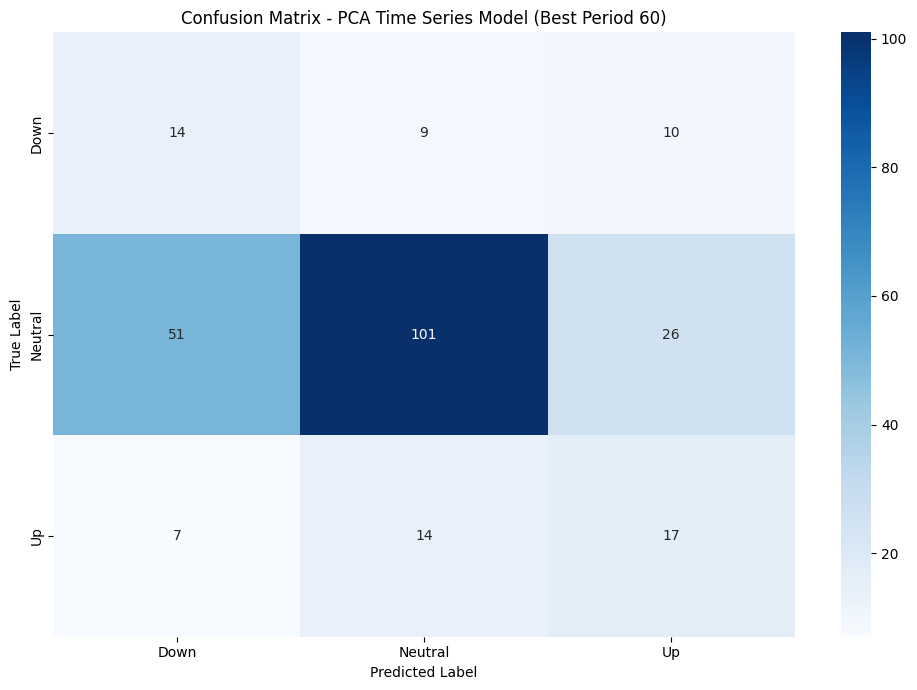


Classification Report:
              precision    recall  f1-score   support

        Down       0.19      0.42      0.27        33
     Neutral       0.81      0.57      0.67       178
          Up       0.32      0.45      0.37        38

    accuracy                           0.53       249
   macro avg       0.44      0.48      0.44       249
weighted avg       0.66      0.53      0.57       249



In [97]:
# Recreate sequences for the best period
pca_ts_X, pca_ts_y = create_sequences(pca_ts_data, target, time_steps=pca_ts_best_period)

# Split the data
pca_ts_X_train, pca_ts_X_test, pca_ts_y_train, pca_ts_y_test = train_test_split(
    pca_ts_X, pca_ts_y, 
    test_size=0.2, 
    random_state=42, 
    stratify=pca_ts_y
)

# Predict on test data
pca_ts_y_pred = pca_ts_best_model.predict(pca_ts_X_test)
pca_ts_y_pred_classes = np.argmax(pca_ts_y_pred, axis=1)
pca_ts_y_true_classes = np.argmax(to_categorical(pca_ts_y_test, num_classes=3), axis=1)

# Create confusion matrix
pca_ts_cm = confusion_matrix(pca_ts_y_true_classes, pca_ts_y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(pca_ts_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Neutral', 'Up'],
            yticklabels=['Down', 'Neutral', 'Up'])
plt.title(f'Confusion Matrix - PCA Time Series Model (Best Period {pca_ts_best_period})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(pca_ts_y_true_classes, pca_ts_y_pred_classes, 
                             target_names=['Down', 'Neutral', 'Up']))